In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import torchvision.transforms as transforms
import pandas as pd

In [2]:
class VideoDataset(Dataset):
    def __init__(self, csv_file, root_dir,output_folder):
        self.csv_file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.file_suffix = '.avi'
        self.video_files = os.listdir(self.root_dir)
        # 读取 root_dir 下的所有视频文件，获取他们的文件名
        self.video_files_name = [i.split('.')[0] for i in self.video_files]
        # 将获得的文件名到 csv 文件中查找对应的标签，csv 文件中的 FileName 是文件名，health 是标签
        self.labels = []
        self.video_useful_name = []
        for i in self.video_files_name:
            self.labels.append(self.csv_file.loc[self.csv_file['FileName'] == i, ' health'].values[0])
            self.video_useful_name.append(i)
        #将self.video_useful_name里面所有的文件都添加上.avi后缀
        self.video_files = [i + self.file_suffix for i in self.video_useful_name]
        self.labels = np.array(self.labels)
        self.output_folder = output_folder
    
    def get_frames(self):
        frames = []
        # 遍历所有视频文件
        for video_file in self.video_files:
            video_path = os.path.join(self.root_dir, video_file)
            video_output_dir = os.path.join(self.output_folder, video_file.split('.')[0])
            cap = cv2.VideoCapture(video_path)
            frame_count = 0
            extracted_frames = []
            ventricular_sizes = []
            while cap.isOpened():
            # 获取视频的第一帧和第二帧，以及视频的宽和高
                ret, frame = cap.read()
                if not ret:
                    break
                frame_path = os.path.join(video_output_dir, f'frame_{frame_count:04d}.png')
                cv2.imwrite(frame_path, frame)
                extracted_frames.append(frame)

                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                blurred = cv2.GaussianBlur(gray, (5, 5), 0)

                _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                largest_contour = max(contours, key=cv2.contourArea) if contours else None

                if largest_contour is not None:
                    ventricular_area = cv2.contourArea(largest_contour)
                else:
                    ventricular_area = 0

                ventricular_sizes.append(ventricular_area)
                frame_count += 1
            cap.release()   
            diastole_frame_index = np.argmax(ventricular_sizes)
            systole_frame_index = np.argmin(ventricular_sizes)
            # print(diastole_frame_index)
            # print(systole_frame_index)
            # # 将 frame1 和 frame2 合并成一个两通道的图片，他们本身就是灰度图
            # print(extracted_frames[diastole_frame_index].shape)
            # print(extracted_frames[systole_frame_index].shape)
            frame = np.concatenate([extracted_frames[diastole_frame_index],extracted_frames[systole_frame_index]], axis=2)
            frame = frame.transpose(2, 0, 1)
            frames.append(frame)
        frames = torch.tensor(frames)
        labels = torch.tensor(self.labels).float()
        print(frames.shape)
        print(labels)
        return frames, labels
testdataset = VideoDataset('/home/curry/code/curry_code_summay/AI/for_dc/FileList_new.csv', '/home/curry/code/视频划分/TEST','/home/curry/code/视频划分/output_folder')
test_frames,test_labels = testdataset.get_frames()
traindataset = VideoDataset('/home/curry/code/curry_code_summay/AI/for_dc/FileList_new.csv', '/home/curry/code/视频划分/TRAIN','/home/curry/code/视频划分/output_folder')
train_frames,train_labels = traindataset.get_frames()
valdataset = VideoDataset('/home/curry/code/curry_code_summay/AI/for_dc/FileList_new.csv', '/home/curry/code/视频划分/VAL','/home/curry/code/视频划分/output_folder')
val_frames,val_labels = valdataset.get_frames()

#将他们转换成 pytorch 的 tensor，作为神经网络的输入
# frames = torch.tensor(frames)
# labels = torch.tensor(labels)

/tmp/ipykernel_16336/1164004502.py:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  frames = torch.tensor(frames)


torch.Size([1277, 6, 112, 112])
tensor([1., 1., 0.,  ..., 0., 1., 0.])
torch.Size([7464, 6, 112, 112])
tensor([1., 1., 0.,  ..., 0., 0., 1.])
torch.Size([1288, 6, 112, 112])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [3]:
from torch.utils.data import TensorDataset
#对trainframe进行数据增强,对testframe不进行数据增强
# train_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(30),
# ])
# train_frames = train_transforms(train_frames)

# 创建 TensorDataset
train_dataset = TensorDataset(train_frames, train_labels)
test_dataset = TensorDataset(test_frames, test_labels)
val_dataset = TensorDataset(val_frames, val_labels)

# 创建 DataLoader
batch_size = 32  # 你可以根据需要调整批次大小
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 检查 DataLoader 中的数据
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i}: inputs shape = {inputs.shape}, labels shape = {labels.shape}")
    break  # 仅检查第一个批次

Batch 0: inputs shape = torch.Size([32, 6, 112, 112]), labels shape = torch.Size([32])


In [4]:
#定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [5]:
#定义ResNet18模型
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=1000):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(25088, num_classes)
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    def forward(self, x):
        out = self.conv1(x)
        #print(out.shape)
        out = self.layer1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = F.avg_pool2d(out, 1)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        # if self.training:
        #     out = self.dropout(out)
        #print(out.shape)
        out = self.fc(out)
        return out

Time cost: 0.0004155508876313618ms
Accuracy of the model on the test images: 76.94%
Epoch [1/100], Loss: 1.4400
AUC: 0.5654
Dice Similarity Coefficient: 0.8689


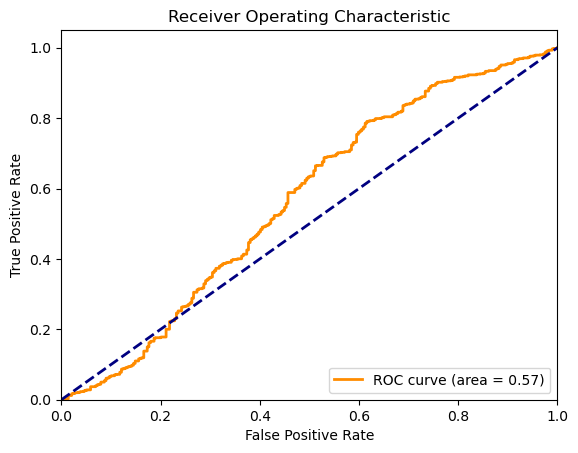

Time cost: 0.00023801156852799836ms
Accuracy of the model on the test images: 77.48%
Epoch [2/100], Loss: 0.7104
AUC: 0.6268
Dice Similarity Coefficient: 0.8728


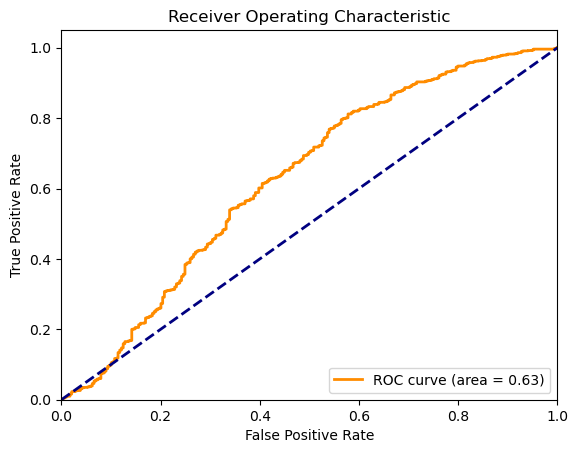

Time cost: 0.00022525850832228933ms
Accuracy of the model on the test images: 78.57%
Epoch [3/100], Loss: 0.5343
AUC: 0.7257
Dice Similarity Coefficient: 0.8770


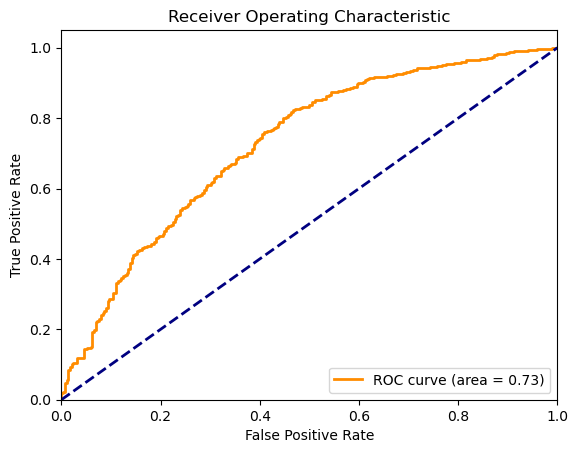

Time cost: 0.00022331456607827565ms
Accuracy of the model on the test images: 80.36%
Epoch [4/100], Loss: 0.4792
AUC: 0.7202
Dice Similarity Coefficient: 0.8848


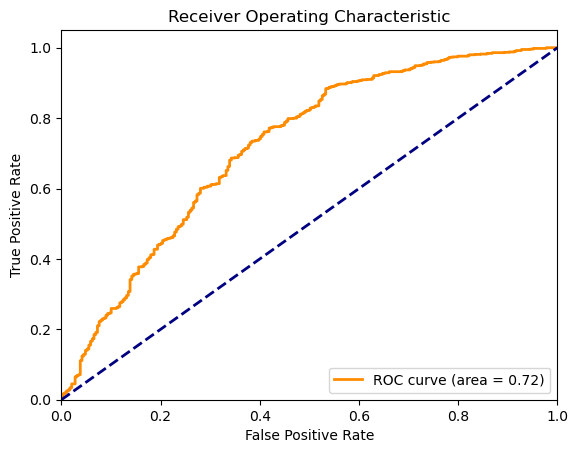

Time cost: 0.00022587555875606431ms
Accuracy of the model on the test images: 80.51%
Epoch [5/100], Loss: 0.4556
AUC: 0.7468
Dice Similarity Coefficient: 0.8845


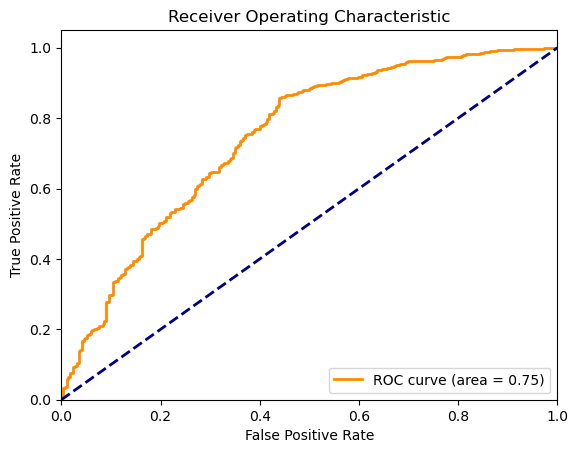

Time cost: 0.00022067142447738228ms
Accuracy of the model on the test images: 81.37%
Epoch [6/100], Loss: 0.4442
AUC: 0.7613
Dice Similarity Coefficient: 0.8907


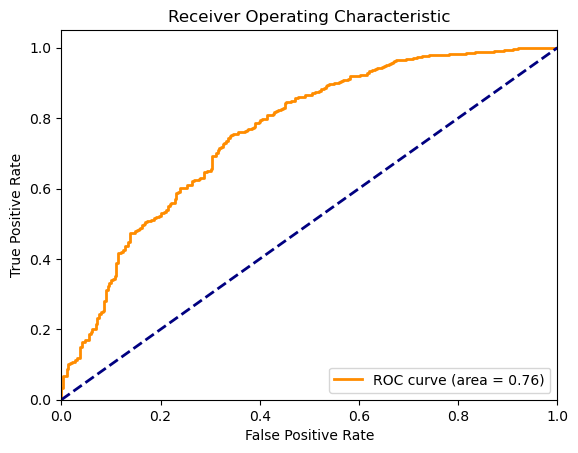

Time cost: 0.00025523670408626785ms
Accuracy of the model on the test images: 81.29%
Epoch [7/100], Loss: 0.4224
AUC: 0.7868
Dice Similarity Coefficient: 0.8852


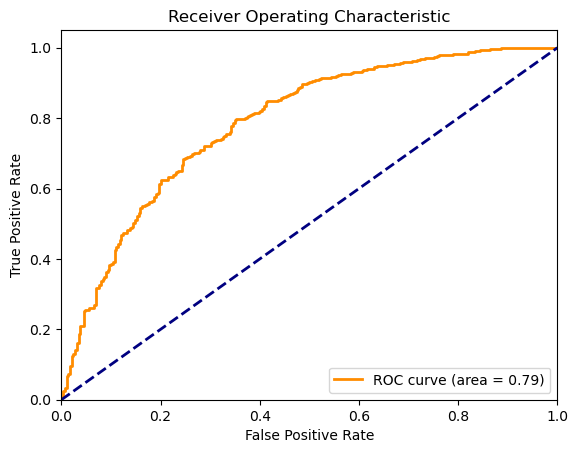

Time cost: 0.00023510480356477814ms
Accuracy of the model on the test images: 81.91%
Epoch [8/100], Loss: 0.4133
AUC: 0.7861
Dice Similarity Coefficient: 0.8896


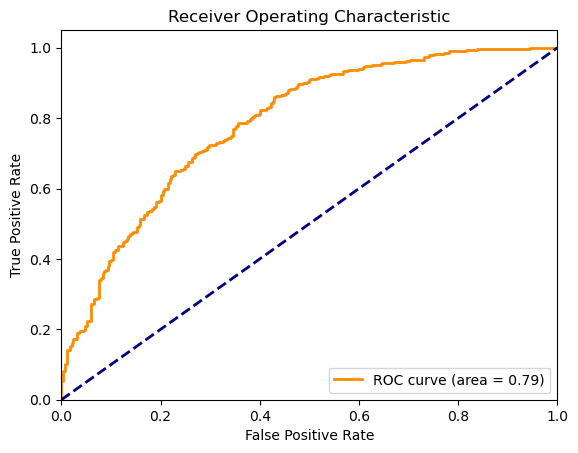

Time cost: 0.00023548940988658645ms
Accuracy of the model on the test images: 79.74%
Epoch [9/100], Loss: 0.4011
AUC: 0.7702
Dice Similarity Coefficient: 0.8709


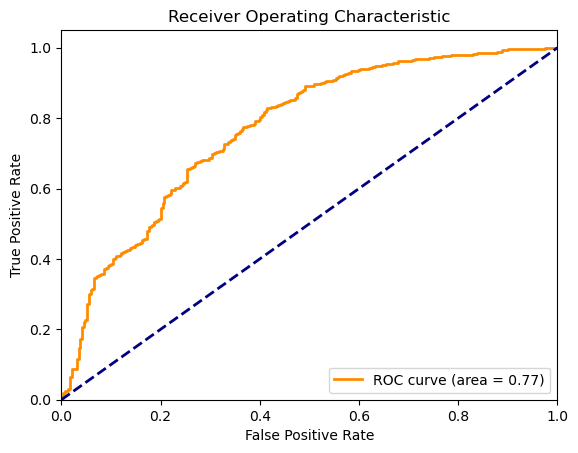

Time cost: 0.00024154565254038167ms
Accuracy of the model on the test images: 81.91%
Epoch [10/100], Loss: 0.4070
AUC: 0.7861
Dice Similarity Coefficient: 0.8897


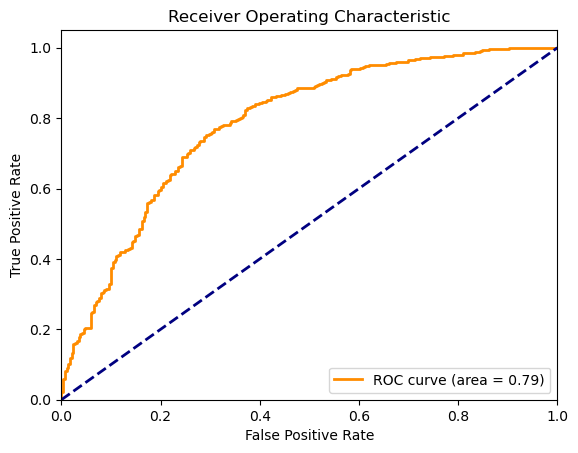

Time cost: 0.00023836630251413224ms
Accuracy of the model on the test images: 79.81%
Epoch [11/100], Loss: 0.3795
AUC: 0.7992
Dice Similarity Coefficient: 0.8695


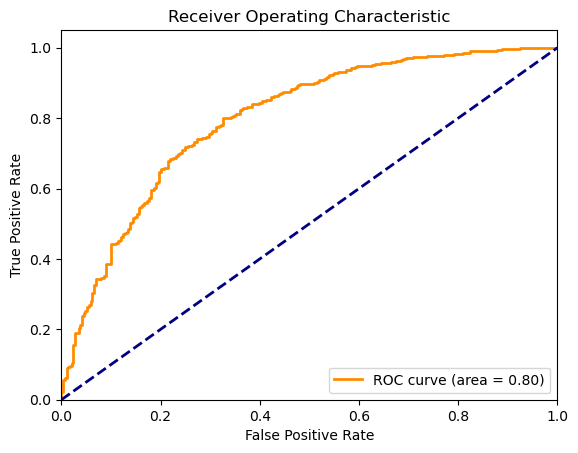

Time cost: 0.00022734546437334436ms
Accuracy of the model on the test images: 80.75%
Epoch [12/100], Loss: 0.3543
AUC: 0.7767
Dice Similarity Coefficient: 0.8800


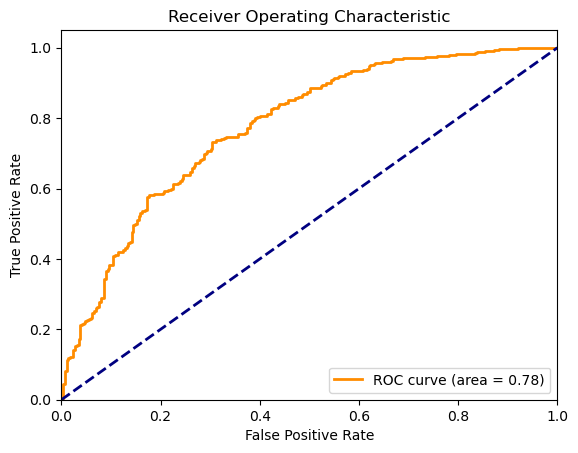

Time cost: 0.0002302806080554553ms
Accuracy of the model on the test images: 82.22%
Epoch [13/100], Loss: 0.3493
AUC: 0.7941
Dice Similarity Coefficient: 0.8930


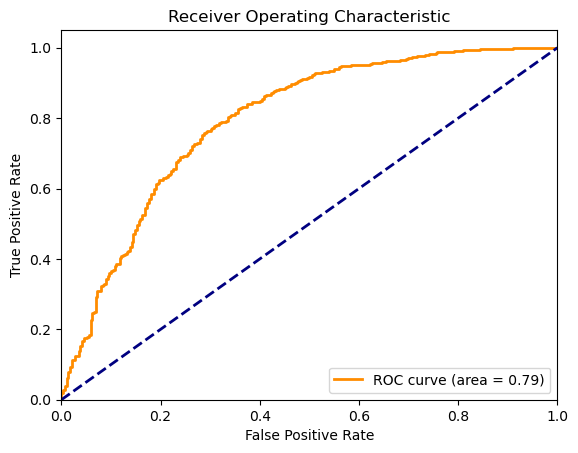

Time cost: 0.00021766496059384864ms
Accuracy of the model on the test images: 82.38%
Epoch [14/100], Loss: 0.3229
AUC: 0.7939
Dice Similarity Coefficient: 0.8913


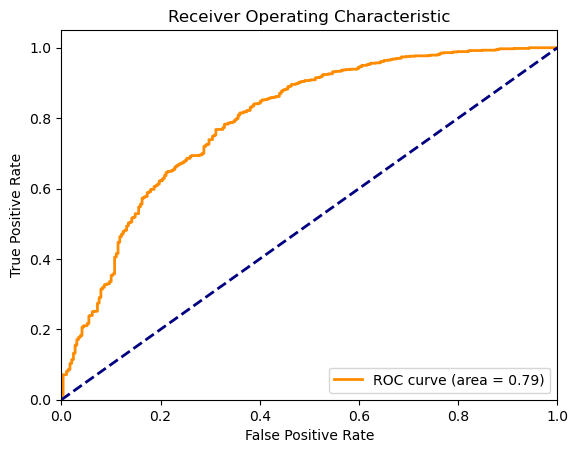

Time cost: 0.00022198338011978377ms
Accuracy of the model on the test images: 81.99%
Epoch [15/100], Loss: 0.2861
AUC: 0.7820
Dice Similarity Coefficient: 0.8910


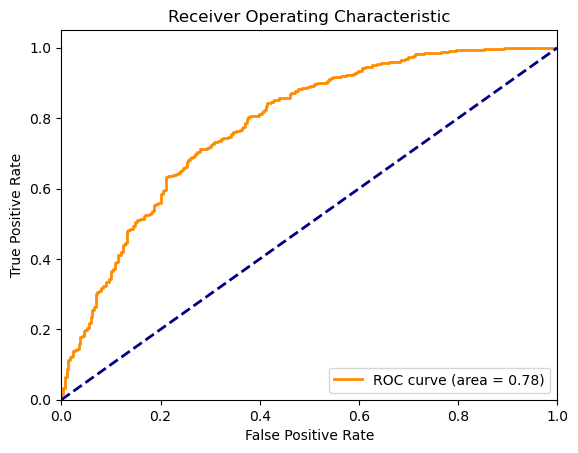

Time cost: 0.00022663524959268472ms
Accuracy of the model on the test images: 79.74%
Epoch [16/100], Loss: 0.2704
AUC: 0.7656
Dice Similarity Coefficient: 0.8782


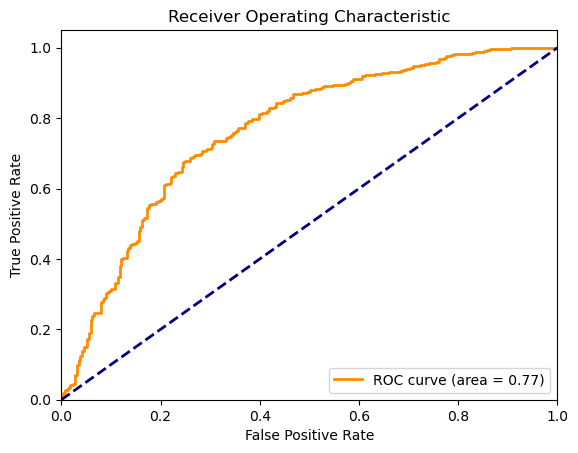

Time cost: 0.0002170357745237059ms
Accuracy of the model on the test images: 80.36%
Epoch [17/100], Loss: 0.2263
AUC: 0.7738
Dice Similarity Coefficient: 0.8800


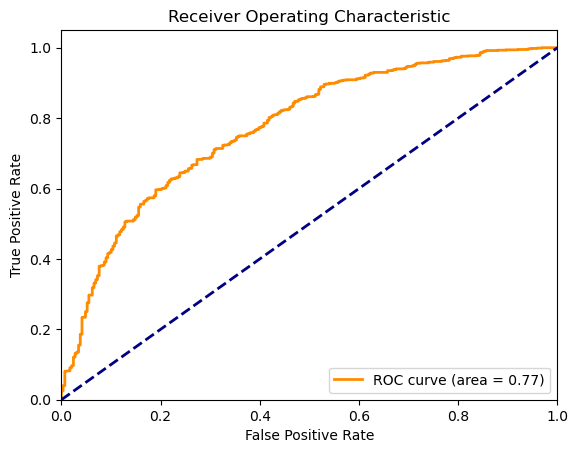

Time cost: 0.0002254765763727127ms
Accuracy of the model on the test images: 78.34%
Epoch [18/100], Loss: 0.1864
AUC: 0.7570
Dice Similarity Coefficient: 0.8622


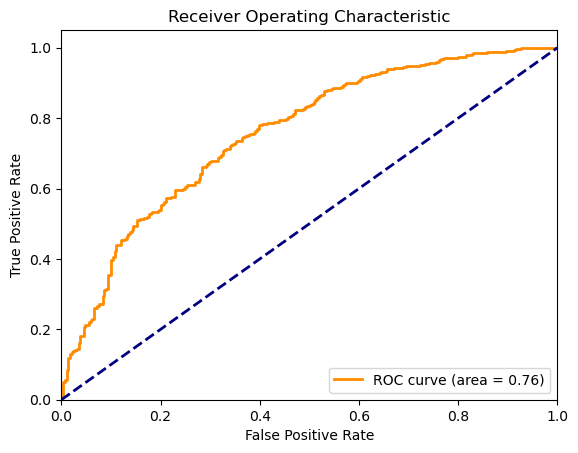

Time cost: 0.0002340191308651105ms
Accuracy of the model on the test images: 80.36%
Epoch [19/100], Loss: 0.1341
AUC: 0.7678
Dice Similarity Coefficient: 0.8813


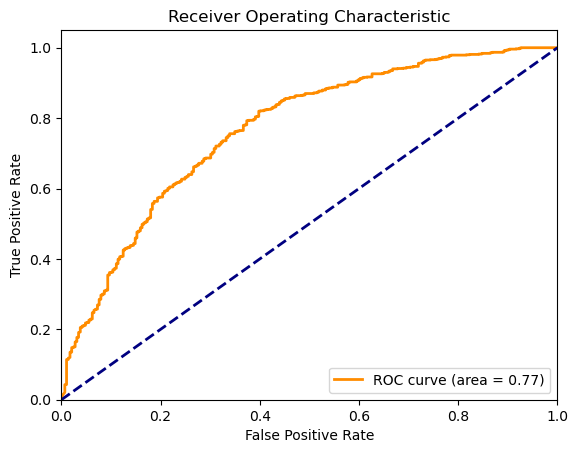

Time cost: 0.00022851459291080246ms
Accuracy of the model on the test images: 77.02%
Epoch [20/100], Loss: 0.1277
AUC: 0.7502
Dice Similarity Coefficient: 0.8555


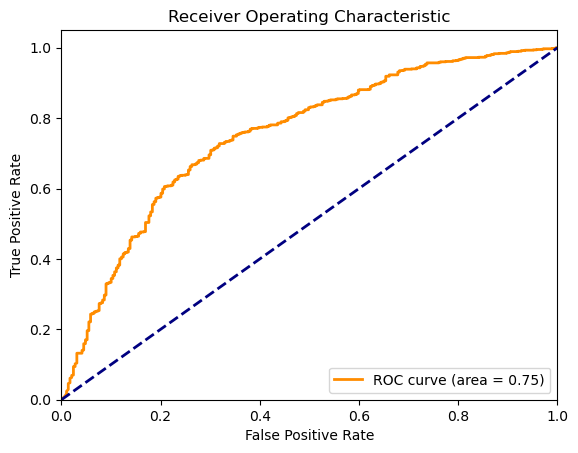

Time cost: 0.000222770702866903ms
Accuracy of the model on the test images: 76.55%
Epoch [21/100], Loss: 0.0933
AUC: 0.7494
Dice Similarity Coefficient: 0.8487


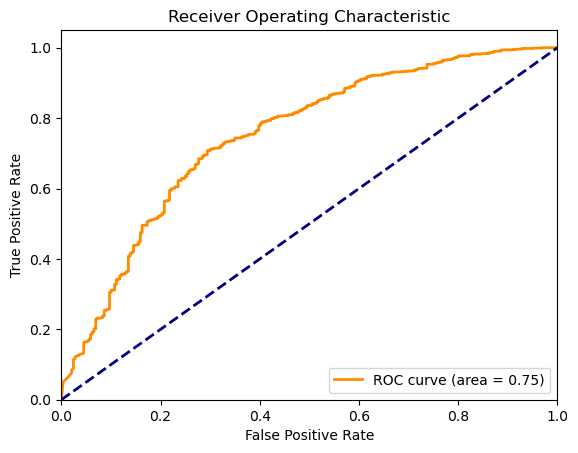

Time cost: 0.00022755307710628167ms
Accuracy of the model on the test images: 77.95%
Epoch [22/100], Loss: 0.0781
AUC: 0.7724
Dice Similarity Coefficient: 0.8579


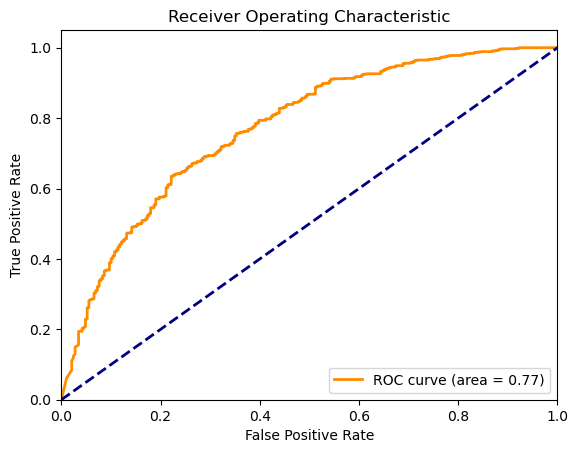

Time cost: 0.0002164103224955225ms
Accuracy of the model on the test images: 75.78%
Epoch [23/100], Loss: 0.0850
AUC: 0.7475
Dice Similarity Coefficient: 0.8424


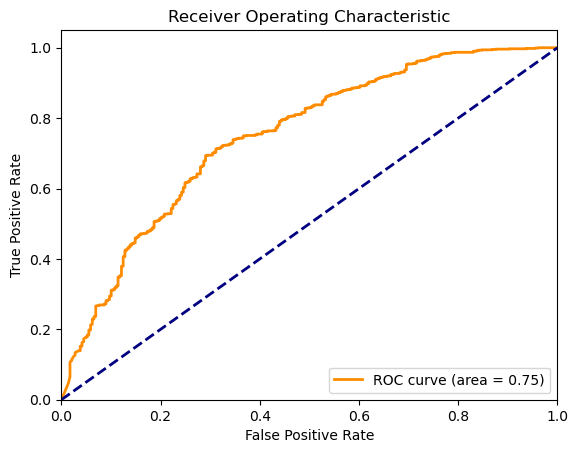

Time cost: 0.00021757272975745384ms
Accuracy of the model on the test images: 78.49%
Epoch [24/100], Loss: 0.0507
AUC: 0.7634
Dice Similarity Coefficient: 0.8670


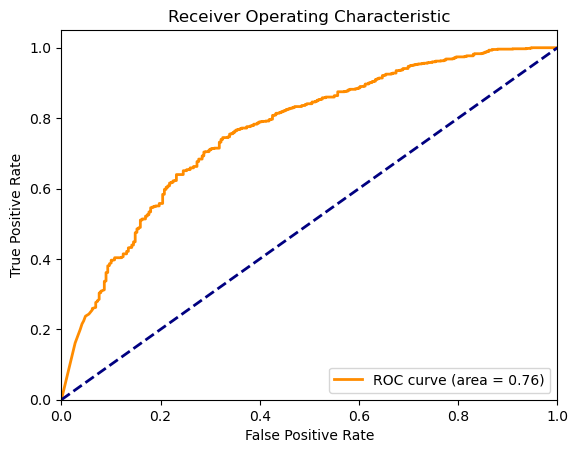

Time cost: 0.00022831986262262475ms
Accuracy of the model on the test images: 75.39%
Epoch [25/100], Loss: 0.0522
AUC: 0.7516
Dice Similarity Coefficient: 0.8379


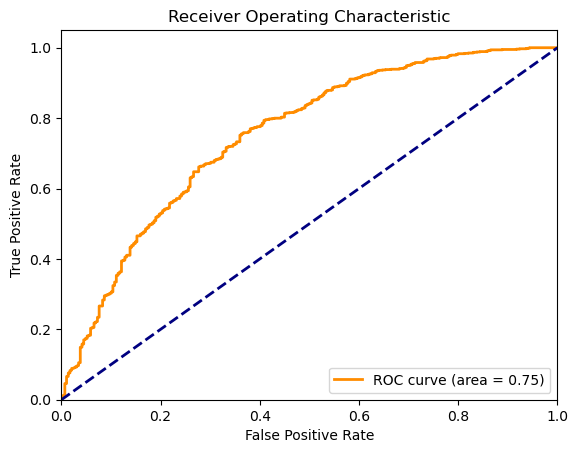

Time cost: 0.0002177258254777853ms
Accuracy of the model on the test images: 76.48%
Epoch [26/100], Loss: 0.0426
AUC: 0.7534
Dice Similarity Coefficient: 0.8472


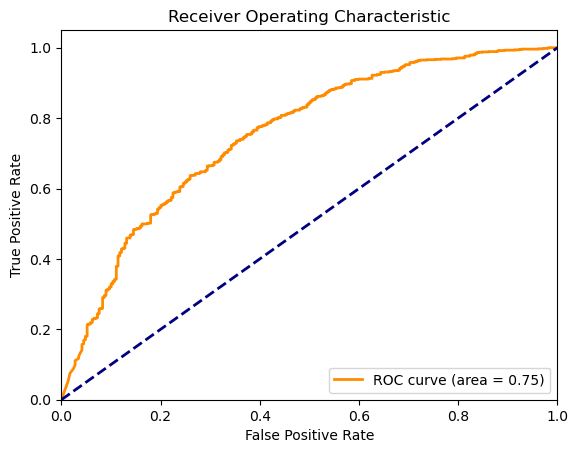

Time cost: 0.00022420532178766764ms
Accuracy of the model on the test images: 76.55%
Epoch [27/100], Loss: 0.0475
AUC: 0.7416
Dice Similarity Coefficient: 0.8482


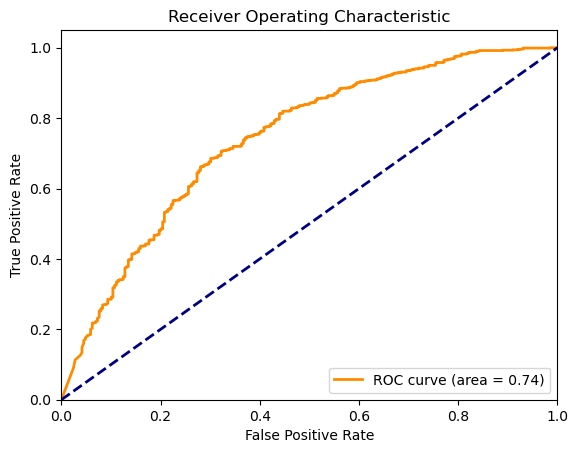

Time cost: 0.00022677191552839524ms
Accuracy of the model on the test images: 77.25%
Epoch [28/100], Loss: 0.0338
AUC: 0.7506
Dice Similarity Coefficient: 0.8531


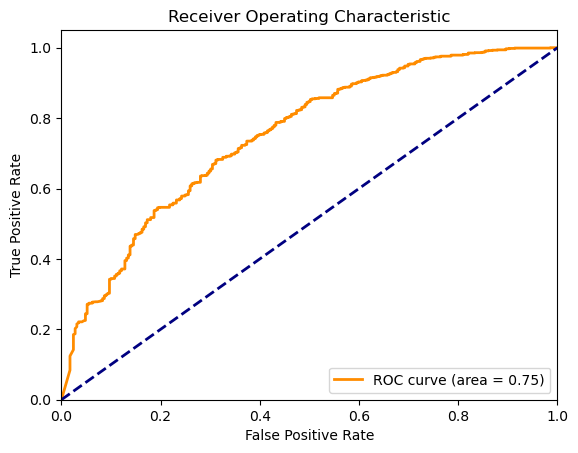

Time cost: 0.00022340698361676843ms
Accuracy of the model on the test images: 77.64%
Epoch [29/100], Loss: 0.0321
AUC: 0.7564
Dice Similarity Coefficient: 0.8588


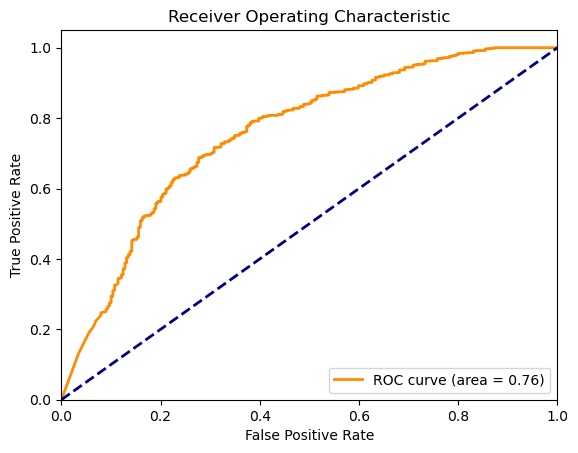

Time cost: 0.00022262227469902068ms
Accuracy of the model on the test images: 78.18%
Epoch [30/100], Loss: 0.0328
AUC: 0.7707
Dice Similarity Coefficient: 0.8601


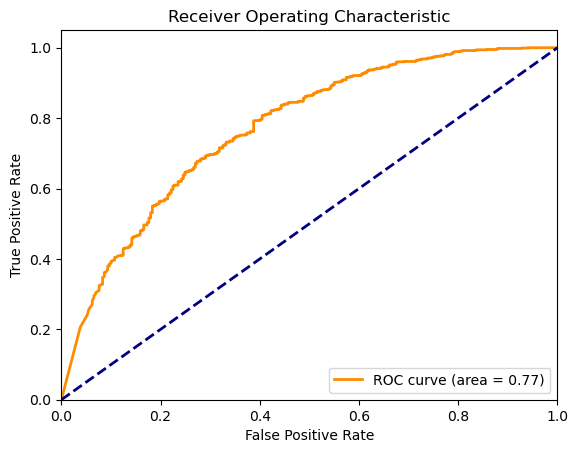

Time cost: 0.0002162751501765957ms
Accuracy of the model on the test images: 77.41%
Epoch [31/100], Loss: 0.0550
AUC: 0.7577
Dice Similarity Coefficient: 0.8550


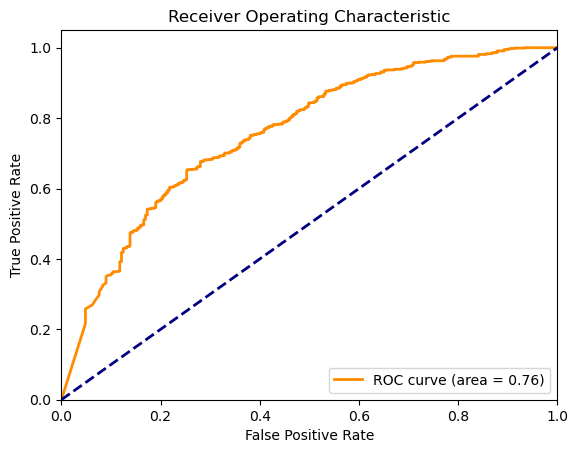

Time cost: 0.00023270773532900292ms
Accuracy of the model on the test images: 76.79%
Epoch [32/100], Loss: 0.0374
AUC: 0.7634
Dice Similarity Coefficient: 0.8506


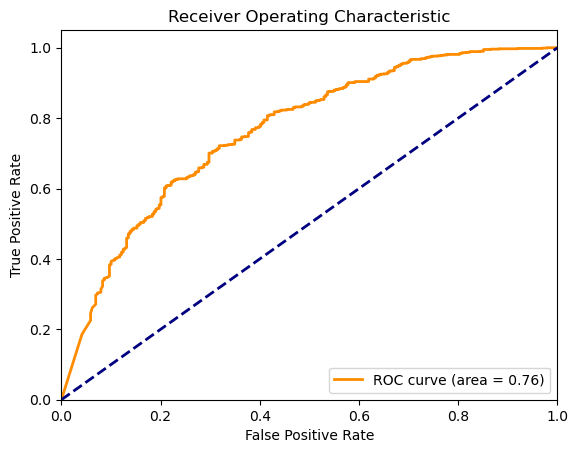

Time cost: 0.0002225530082206756ms
Accuracy of the model on the test images: 80.90%
Epoch [33/100], Loss: 0.0383
AUC: 0.7735
Dice Similarity Coefficient: 0.8843


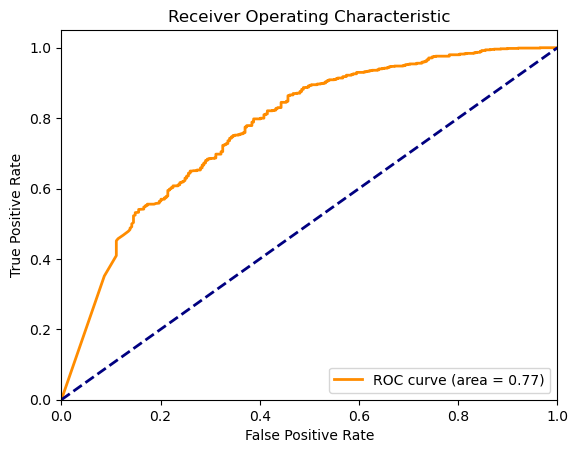

Time cost: 0.00021730107820491448ms
Accuracy of the model on the test images: 77.48%
Epoch [34/100], Loss: 0.0112
AUC: 0.7626
Dice Similarity Coefficient: 0.8567


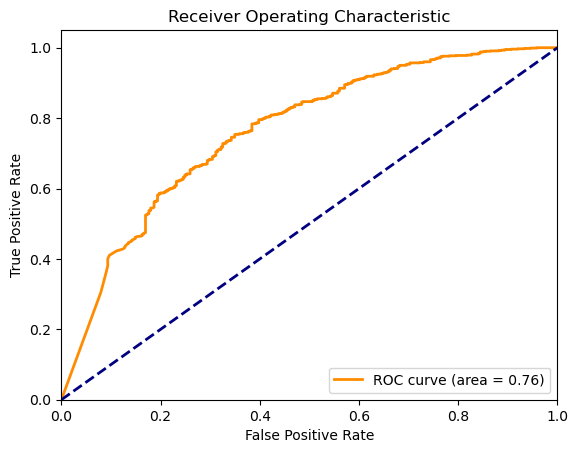

Time cost: 0.00021829806740804864ms
Accuracy of the model on the test images: 78.65%
Epoch [35/100], Loss: 0.0301
AUC: 0.7792
Dice Similarity Coefficient: 0.8620


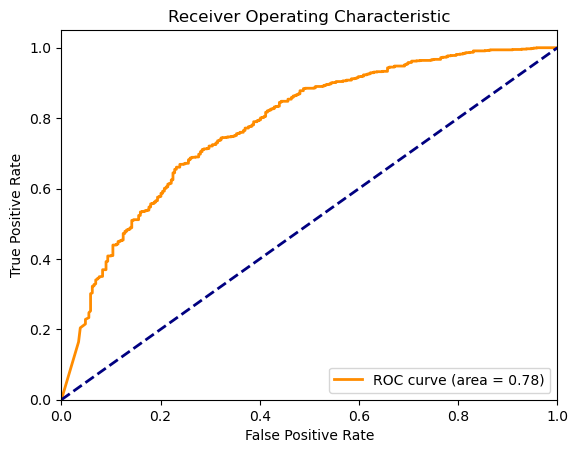

Time cost: 0.00022797110310362575ms
Accuracy of the model on the test images: 80.28%
Epoch [36/100], Loss: 0.0559
AUC: 0.7743
Dice Similarity Coefficient: 0.8793


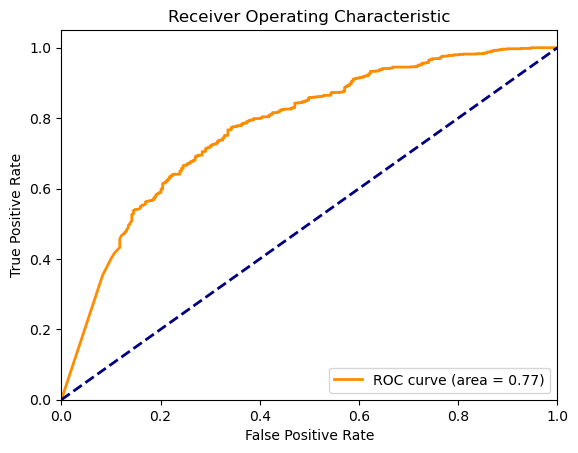

Time cost: 0.00022404606489810332ms
Accuracy of the model on the test images: 80.28%
Epoch [37/100], Loss: 0.0322
AUC: 0.7731
Dice Similarity Coefficient: 0.8769


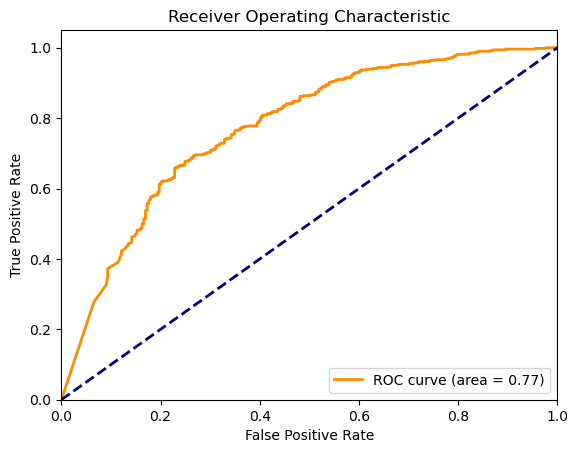

Time cost: 0.00022513248440616282ms
Accuracy of the model on the test images: 76.71%
Epoch [38/100], Loss: 0.0264
AUC: 0.7549
Dice Similarity Coefficient: 0.8495


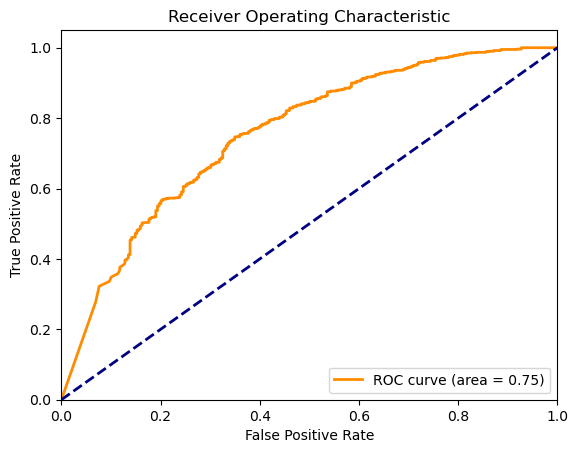

Time cost: 0.00022107843505094643ms
Accuracy of the model on the test images: 79.11%
Epoch [39/100], Loss: 0.0200
AUC: 0.7655
Dice Similarity Coefficient: 0.8681


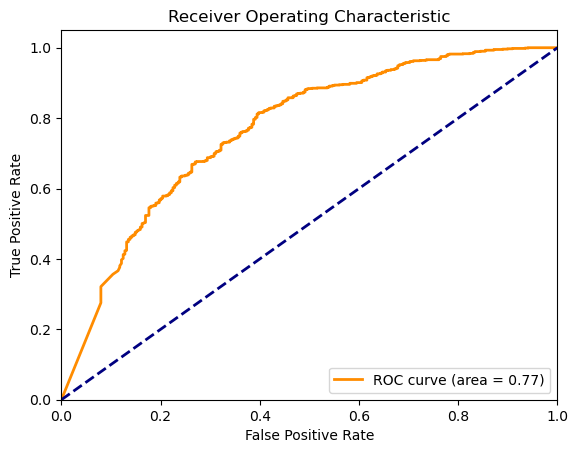

Time cost: 0.00022804503713441996ms
Accuracy of the model on the test images: 77.33%
Epoch [40/100], Loss: 0.0326
AUC: 0.7576
Dice Similarity Coefficient: 0.8507


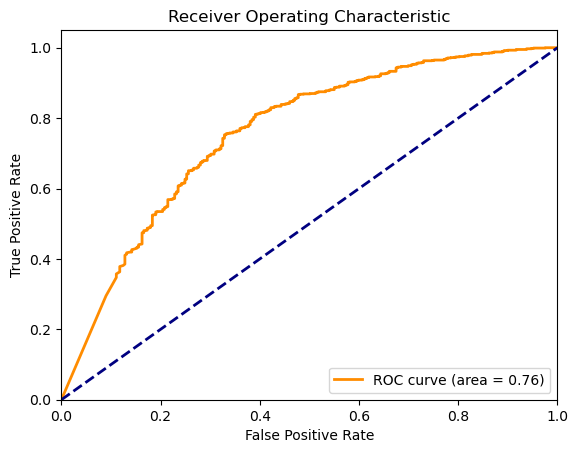

Time cost: 0.00022795075257494755ms
Accuracy of the model on the test images: 80.05%
Epoch [41/100], Loss: 0.0172
AUC: 0.7675
Dice Similarity Coefficient: 0.8741


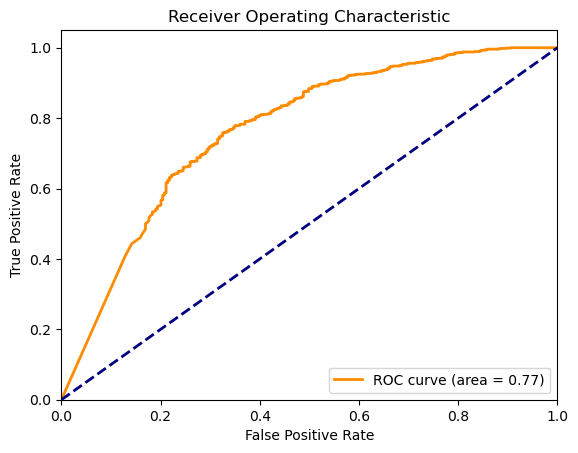

Time cost: 0.00022224831039679638ms
Accuracy of the model on the test images: 78.34%
Epoch [42/100], Loss: 0.0258
AUC: 0.7641
Dice Similarity Coefficient: 0.8610


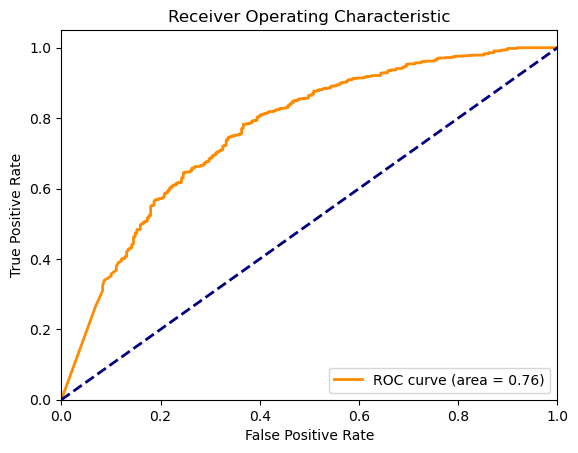

Time cost: 0.00021756600848192709ms
Accuracy of the model on the test images: 77.33%
Epoch [43/100], Loss: 0.0230
AUC: 0.7338
Dice Similarity Coefficient: 0.8564


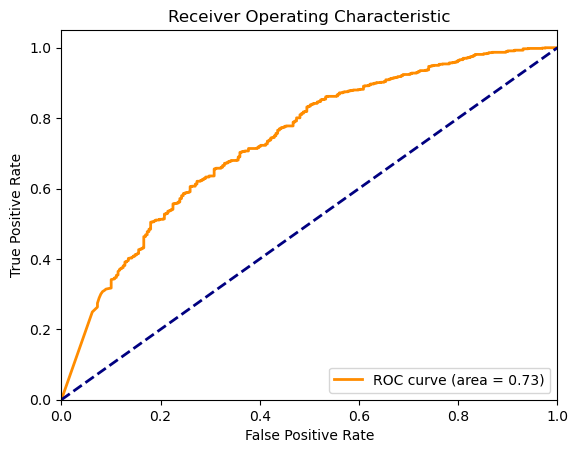

Time cost: 0.00021790468608763597ms
Accuracy of the model on the test images: 79.81%
Epoch [44/100], Loss: 0.0338
AUC: 0.7700
Dice Similarity Coefficient: 0.8729


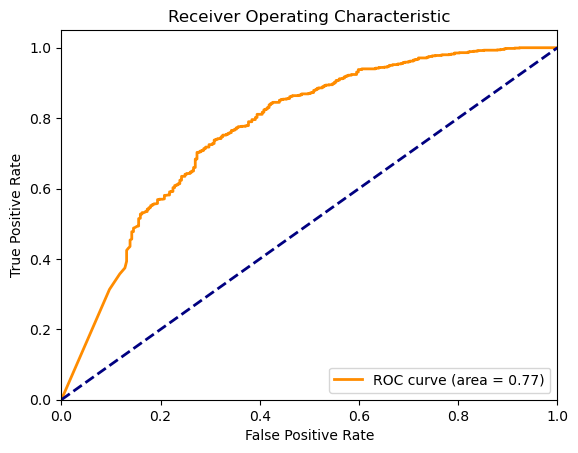

Time cost: 0.0002180837333995846ms
Accuracy of the model on the test images: 79.35%
Epoch [45/100], Loss: 0.0221
AUC: 0.7680
Dice Similarity Coefficient: 0.8697


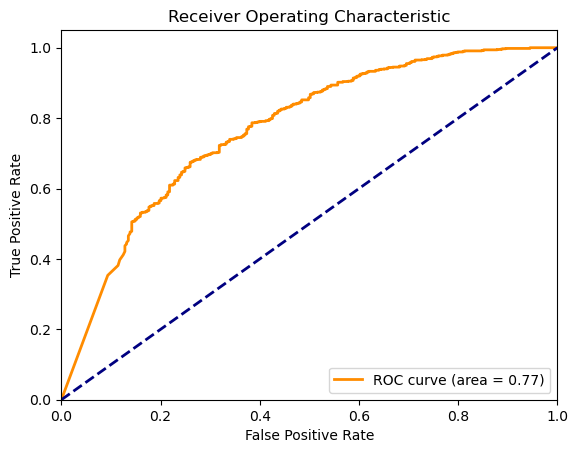

Time cost: 0.00022137510468461314ms
Accuracy of the model on the test images: 78.80%
Epoch [46/100], Loss: 0.0085
AUC: 0.7525
Dice Similarity Coefficient: 0.8669


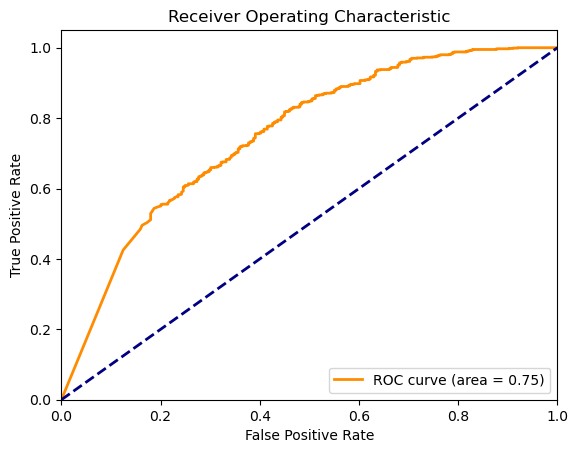

Time cost: 0.00022141431212518582ms
Accuracy of the model on the test images: 78.80%
Epoch [47/100], Loss: 0.0211
AUC: 0.7643
Dice Similarity Coefficient: 0.8688


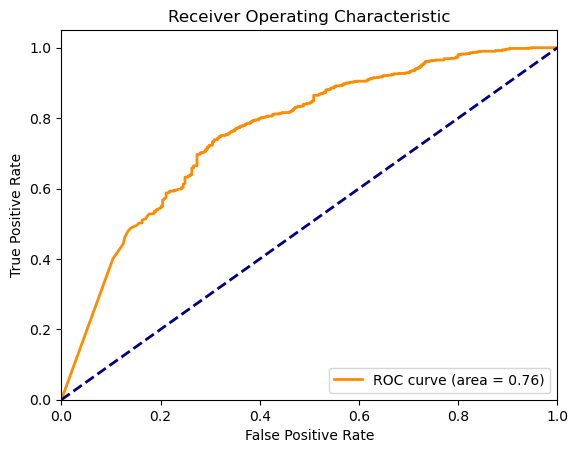

Time cost: 0.00022706989207674772ms
Accuracy of the model on the test images: 79.19%
Epoch [48/100], Loss: 0.0147
AUC: 0.7560
Dice Similarity Coefficient: 0.8700


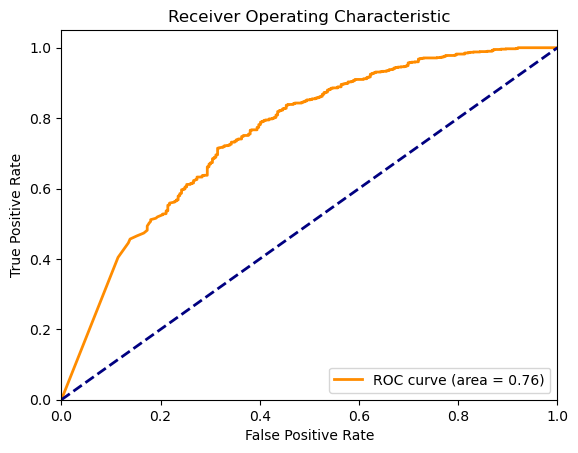

Time cost: 0.0002185413402416973ms
Accuracy of the model on the test images: 78.88%
Epoch [49/100], Loss: 0.0248
AUC: 0.7634
Dice Similarity Coefficient: 0.8685


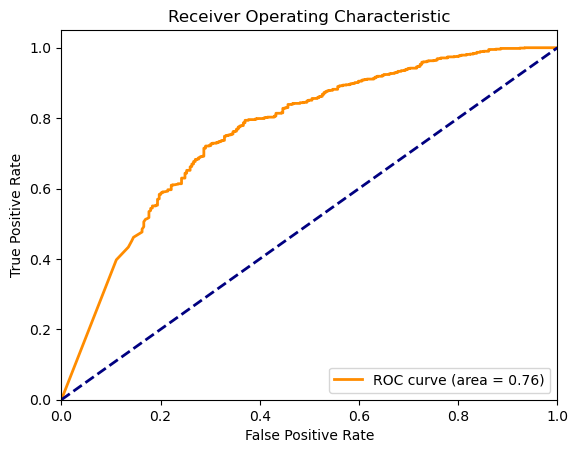

Time cost: 0.00023701401921857028ms
Accuracy of the model on the test images: 79.11%
Epoch [50/100], Loss: 0.0292
AUC: 0.7474
Dice Similarity Coefficient: 0.8706


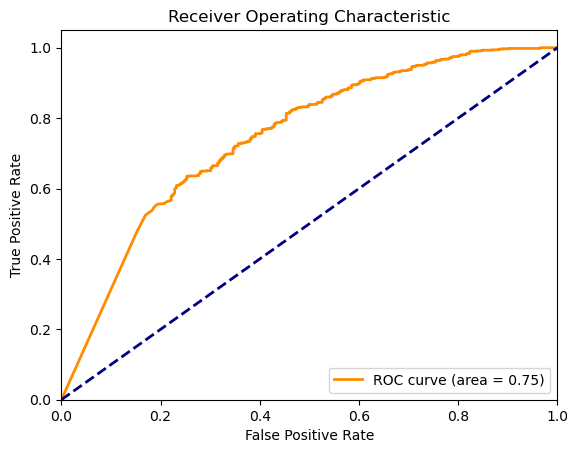

Time cost: 0.000217582624968646ms
Accuracy of the model on the test images: 80.05%
Epoch [51/100], Loss: 0.0548
AUC: 0.7592
Dice Similarity Coefficient: 0.8758


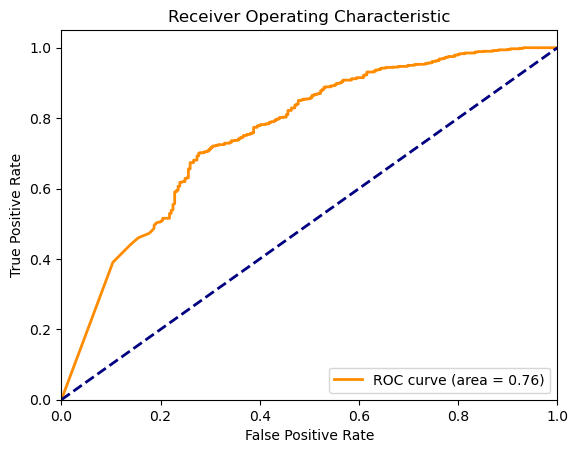

Time cost: 0.00021549958966164825ms
Accuracy of the model on the test images: 78.96%
Epoch [52/100], Loss: 0.0153
AUC: 0.7428
Dice Similarity Coefficient: 0.8700


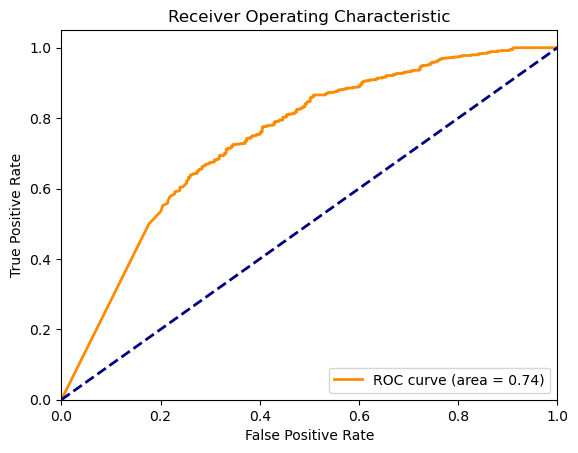

Time cost: 0.00021899595985024257ms
Accuracy of the model on the test images: 79.27%
Epoch [53/100], Loss: 0.0192
AUC: 0.7638
Dice Similarity Coefficient: 0.8711


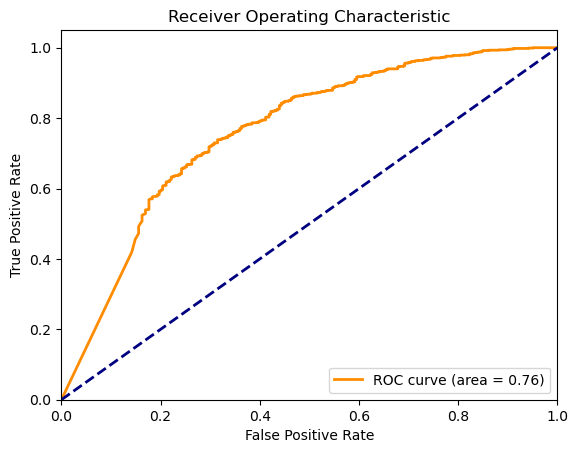

Time cost: 0.0002167686038215177ms
Accuracy of the model on the test images: 79.89%
Epoch [54/100], Loss: 0.0099
AUC: 0.7564
Dice Similarity Coefficient: 0.8755


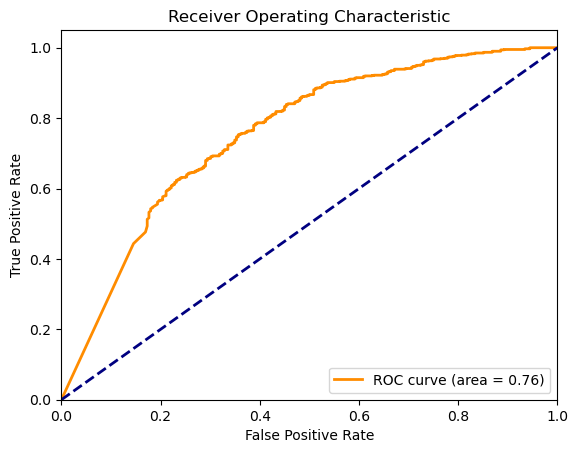

Time cost: 0.0002253161992705606ms
Accuracy of the model on the test images: 79.43%
Epoch [55/100], Loss: 0.0239
AUC: 0.7689
Dice Similarity Coefficient: 0.8722


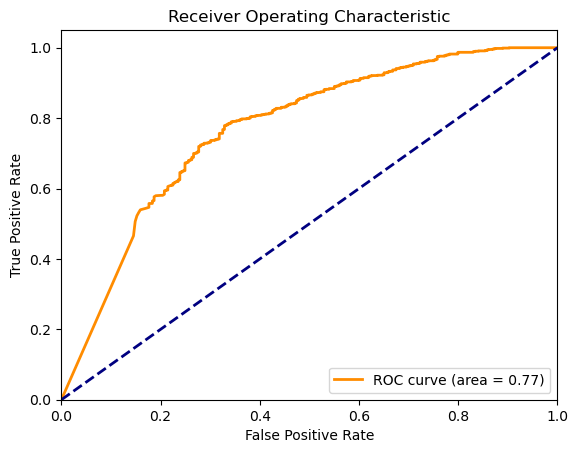

Time cost: 0.00023090960742350004ms
Accuracy of the model on the test images: 77.48%
Epoch [56/100], Loss: 0.0169
AUC: 0.7650
Dice Similarity Coefficient: 0.8563


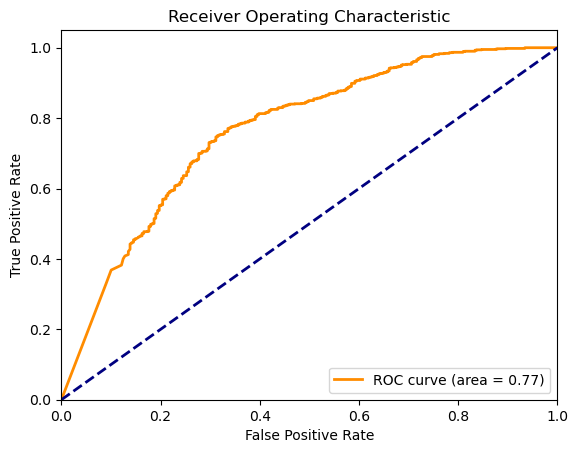

Time cost: 0.0002166067331025819ms
Accuracy of the model on the test images: 78.03%
Epoch [57/100], Loss: 0.0114
AUC: 0.7718
Dice Similarity Coefficient: 0.8579


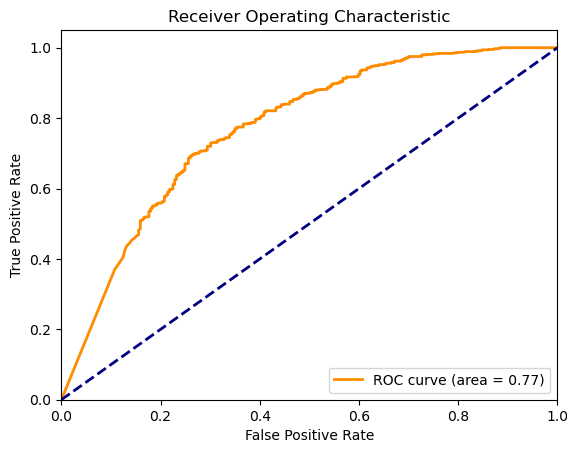

Time cost: 0.00022502120995577556ms
Accuracy of the model on the test images: 74.61%
Epoch [58/100], Loss: 0.0192
AUC: 0.7389
Dice Similarity Coefficient: 0.8305


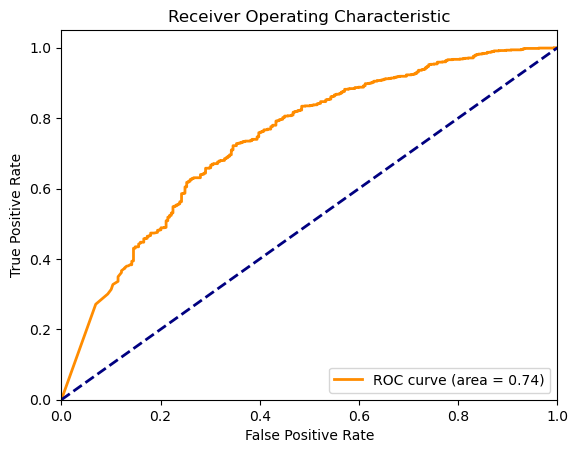

Time cost: 0.0002169801372985123ms
Accuracy of the model on the test images: 77.87%
Epoch [59/100], Loss: 0.0215
AUC: 0.7648
Dice Similarity Coefficient: 0.8594


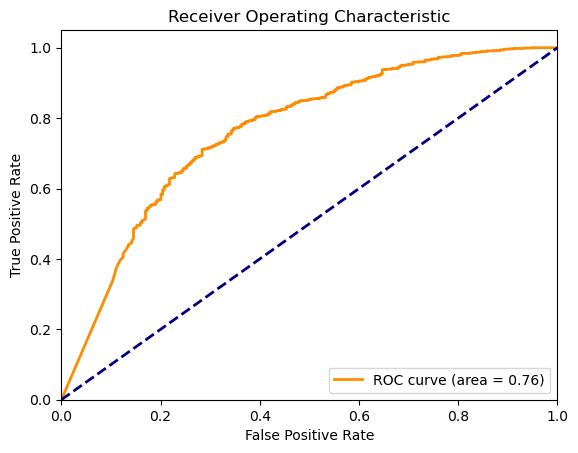

Time cost: 0.00022224364284434726ms
Accuracy of the model on the test images: 79.58%
Epoch [60/100], Loss: 0.0041
AUC: 0.7639
Dice Similarity Coefficient: 0.8721


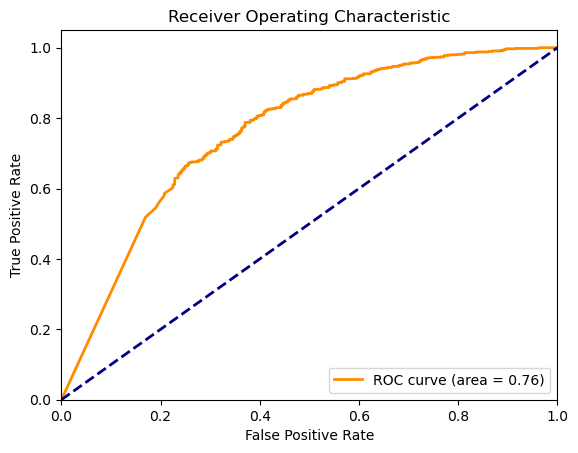

Time cost: 0.00021627253634722417ms
Accuracy of the model on the test images: 78.34%
Epoch [61/100], Loss: 0.0042
AUC: 0.7538
Dice Similarity Coefficient: 0.8637


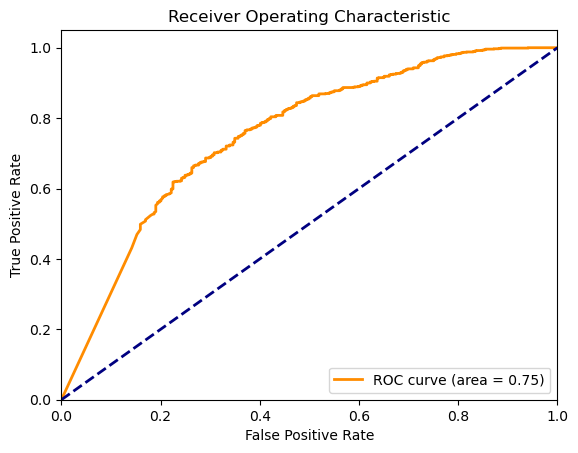

Time cost: 0.00022786953716233266ms
Accuracy of the model on the test images: 78.11%
Epoch [62/100], Loss: 0.0229
AUC: 0.7598
Dice Similarity Coefficient: 0.8597


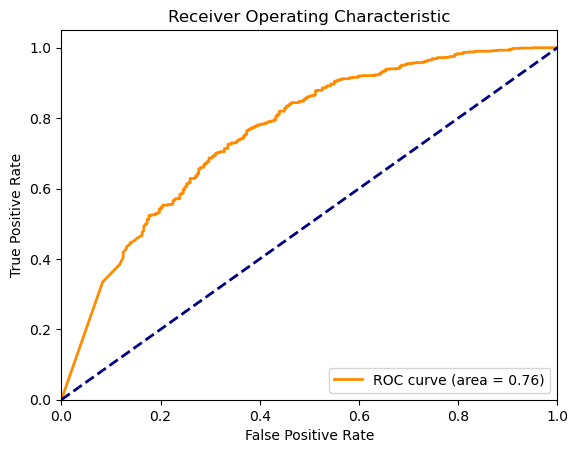

Time cost: 0.0002214643482874405ms
Accuracy of the model on the test images: 79.97%
Epoch [63/100], Loss: 0.0326
AUC: 0.7643
Dice Similarity Coefficient: 0.8760


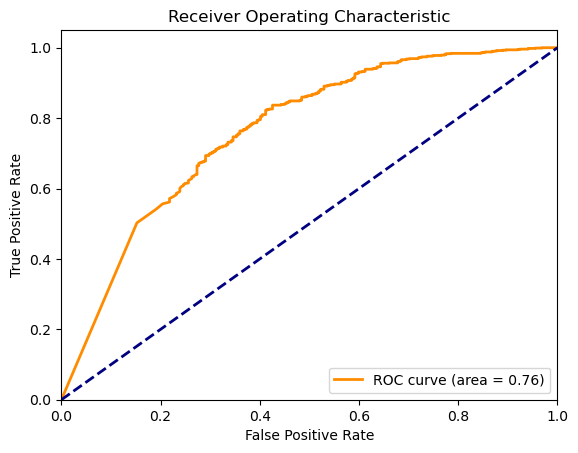

Time cost: 0.00021962159858052396ms
Accuracy of the model on the test images: 78.65%
Epoch [64/100], Loss: 0.0419
AUC: 0.7663
Dice Similarity Coefficient: 0.8653


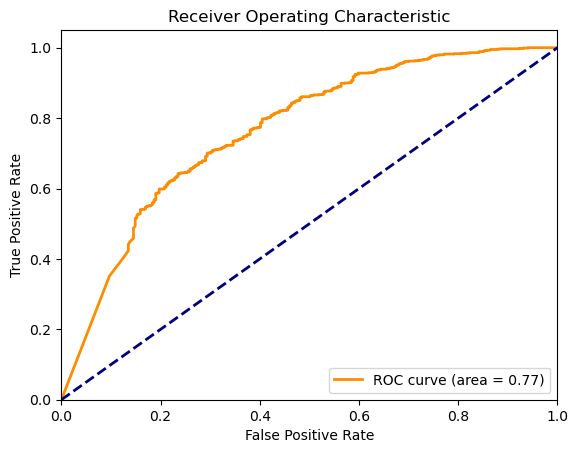

Time cost: 0.00021693495539080472ms
Accuracy of the model on the test images: 79.04%
Epoch [65/100], Loss: 0.0167
AUC: 0.7729
Dice Similarity Coefficient: 0.8674


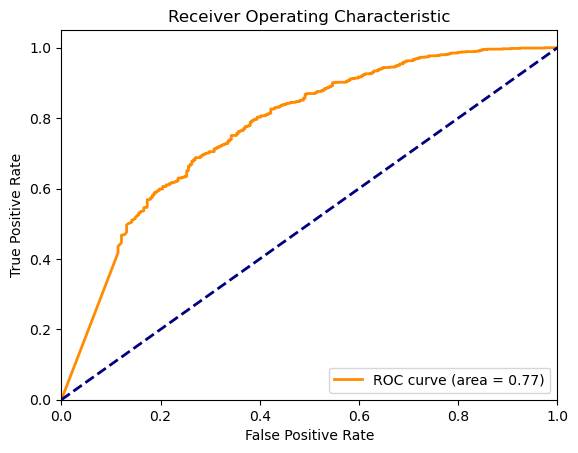

Time cost: 0.00022636378474224332ms
Accuracy of the model on the test images: 80.90%
Epoch [66/100], Loss: 0.0098
AUC: 0.7694
Dice Similarity Coefficient: 0.8801


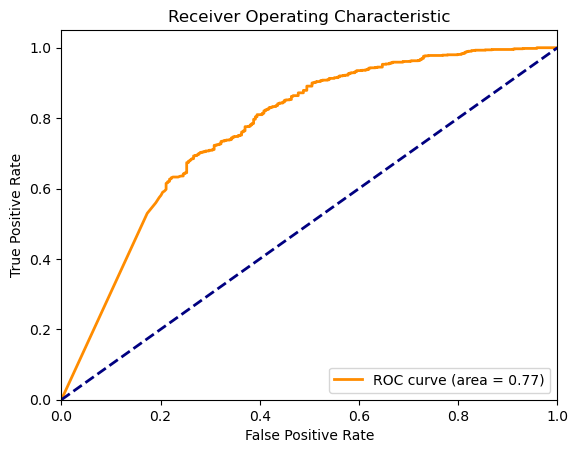

Time cost: 0.00021606716403946245ms
Accuracy of the model on the test images: 79.66%
Epoch [67/100], Loss: 0.0441
AUC: 0.7491
Dice Similarity Coefficient: 0.8748


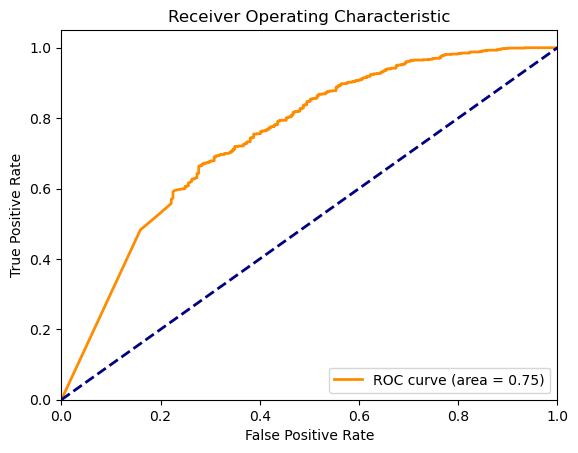

Time cost: 0.0002215072897699725ms
Accuracy of the model on the test images: 78.73%
Epoch [68/100], Loss: 0.0148
AUC: 0.7626
Dice Similarity Coefficient: 0.8648


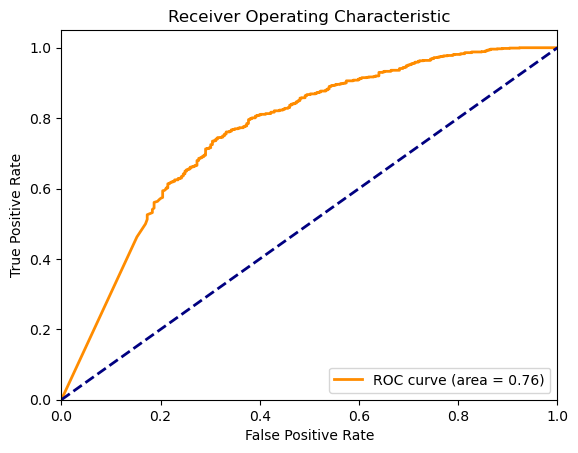

Time cost: 0.00021503096739575558ms
Accuracy of the model on the test images: 78.57%
Epoch [69/100], Loss: 0.0170
AUC: 0.7547
Dice Similarity Coefficient: 0.8660


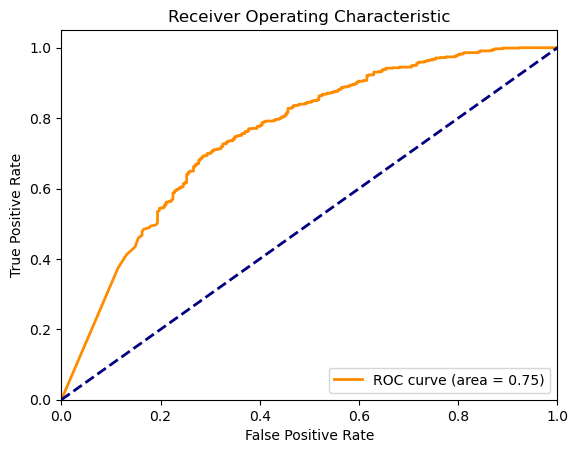

Time cost: 0.0002267862915899386ms
Accuracy of the model on the test images: 80.90%
Epoch [70/100], Loss: 0.0110
AUC: 0.7689
Dice Similarity Coefficient: 0.8827


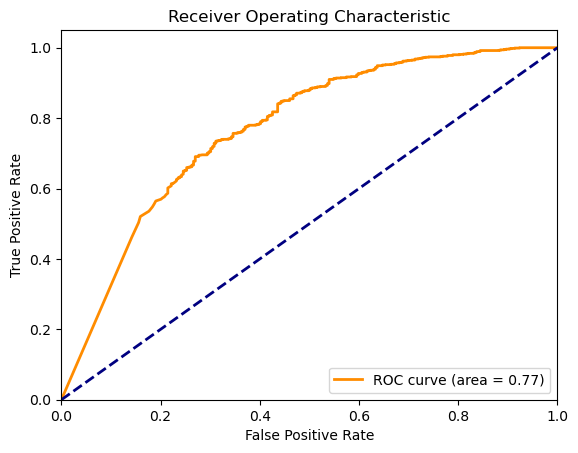

Time cost: 0.0002159015592785673ms
Accuracy of the model on the test images: 79.81%
Epoch [71/100], Loss: 0.0232
AUC: 0.7706
Dice Similarity Coefficient: 0.8742


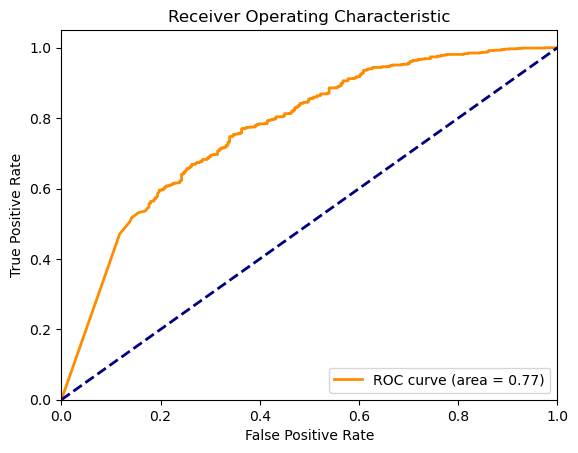

Time cost: 0.0002284240423932893ms
Accuracy of the model on the test images: 79.35%
Epoch [72/100], Loss: 0.0059
AUC: 0.7553
Dice Similarity Coefficient: 0.8702


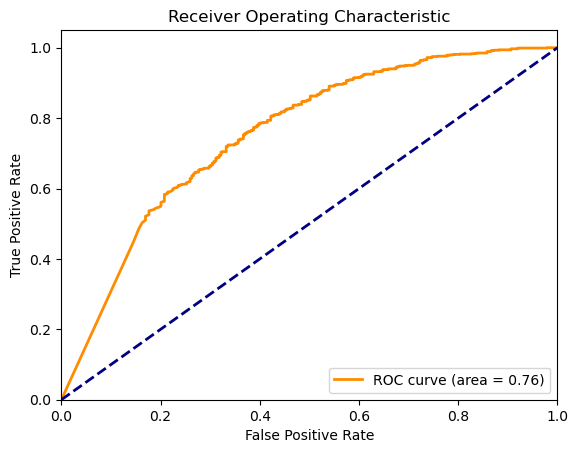

Time cost: 0.00021558173858475294ms
Accuracy of the model on the test images: 78.96%
Epoch [73/100], Loss: 0.0040
AUC: 0.7519
Dice Similarity Coefficient: 0.8677


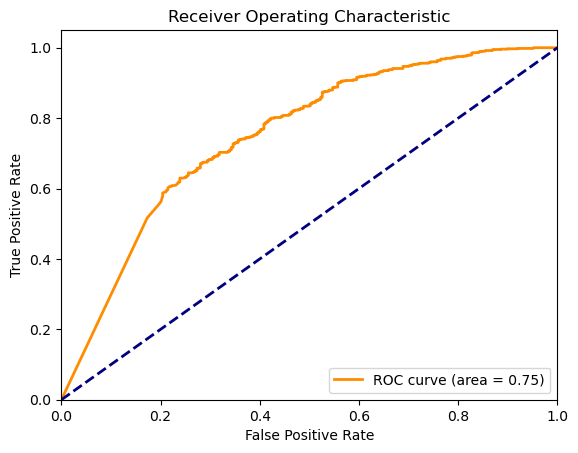

Time cost: 0.00022219902104293358ms
Accuracy of the model on the test images: 78.80%
Epoch [74/100], Loss: 0.0082
AUC: 0.7503
Dice Similarity Coefficient: 0.8666


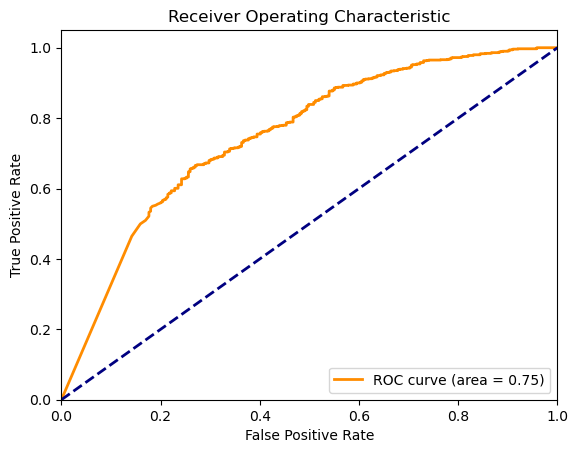

Time cost: 0.0002245016180171384ms
Accuracy of the model on the test images: 77.10%
Epoch [75/100], Loss: 0.0151
AUC: 0.7496
Dice Similarity Coefficient: 0.8539


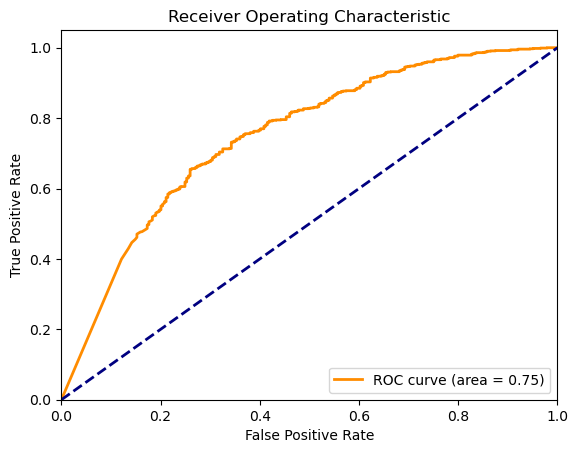

Time cost: 0.00021925958321256943ms
Accuracy of the model on the test images: 78.34%
Epoch [76/100], Loss: 0.0199
AUC: 0.7621
Dice Similarity Coefficient: 0.8649


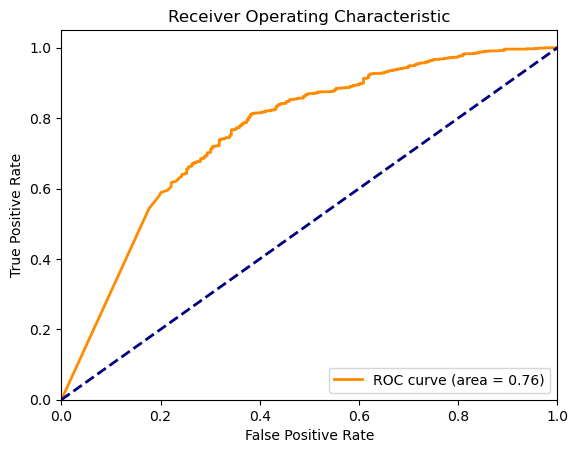

Time cost: 0.00022287525604176354ms
Accuracy of the model on the test images: 79.27%
Epoch [77/100], Loss: 0.0071
AUC: 0.7634
Dice Similarity Coefficient: 0.8693


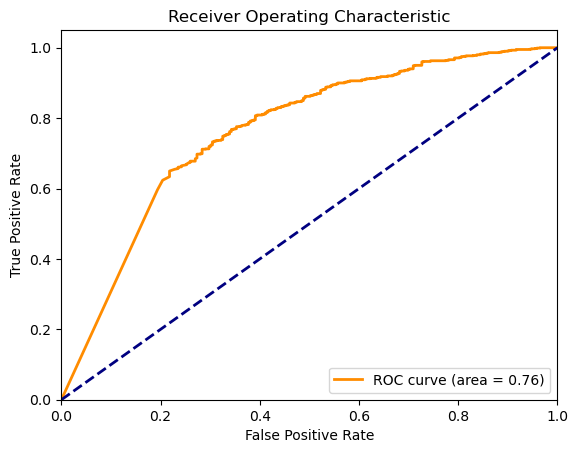

Time cost: 0.0002181040839282628ms
Accuracy of the model on the test images: 75.47%
Epoch [78/100], Loss: 0.0173
AUC: 0.7622
Dice Similarity Coefficient: 0.8389


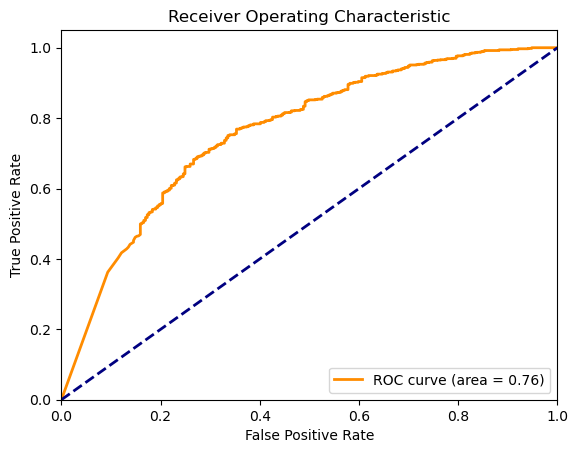

Time cost: 0.0002233169932055492ms
Accuracy of the model on the test images: 79.97%
Epoch [79/100], Loss: 0.0208
AUC: 0.7492
Dice Similarity Coefficient: 0.8748


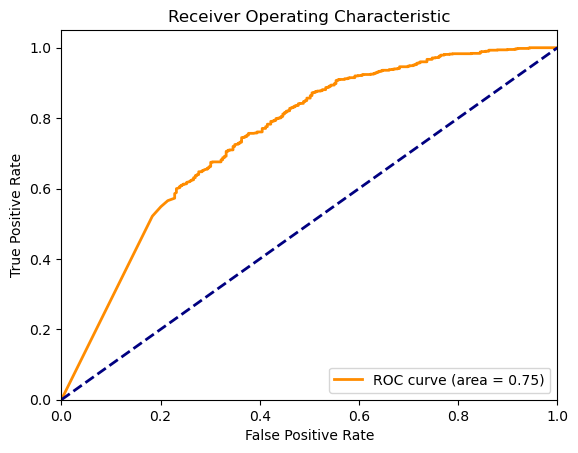

Time cost: 0.00021472701638026824ms
Accuracy of the model on the test images: 78.80%
Epoch [80/100], Loss: 0.0203
AUC: 0.7660
Dice Similarity Coefficient: 0.8637


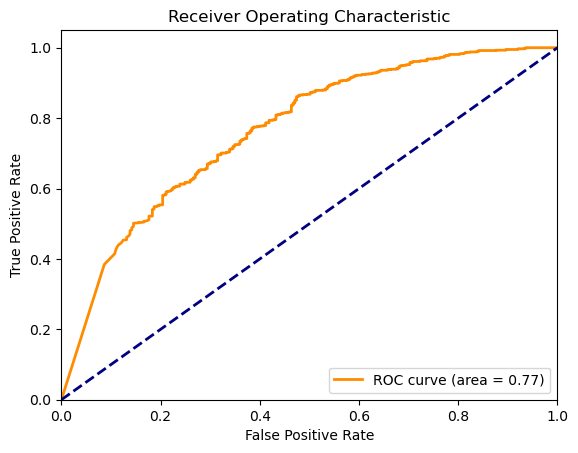

Time cost: 0.00021947933158187447ms
Accuracy of the model on the test images: 79.81%
Epoch [81/100], Loss: 0.0076
AUC: 0.7438
Dice Similarity Coefficient: 0.8749


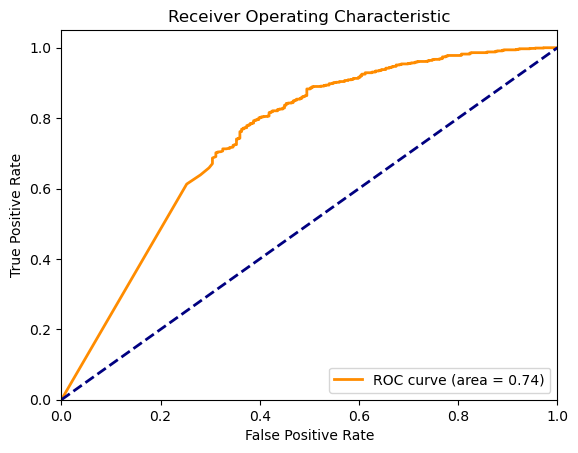

Time cost: 0.00021464281373408594ms
Accuracy of the model on the test images: 80.36%
Epoch [82/100], Loss: 0.0023
AUC: 0.7475
Dice Similarity Coefficient: 0.8775


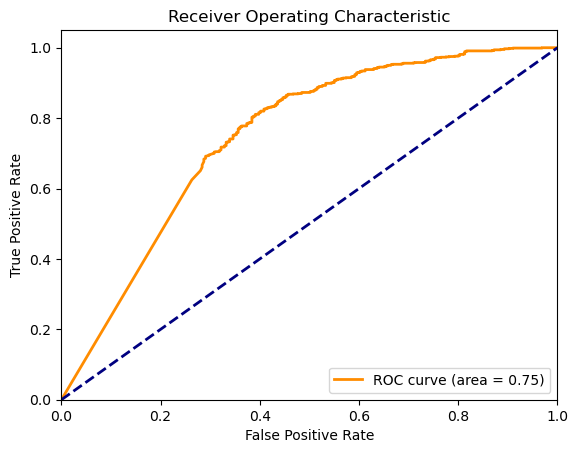

Time cost: 0.00021441951802491955ms
Accuracy of the model on the test images: 79.35%
Epoch [83/100], Loss: 0.0094
AUC: 0.7466
Dice Similarity Coefficient: 0.8712


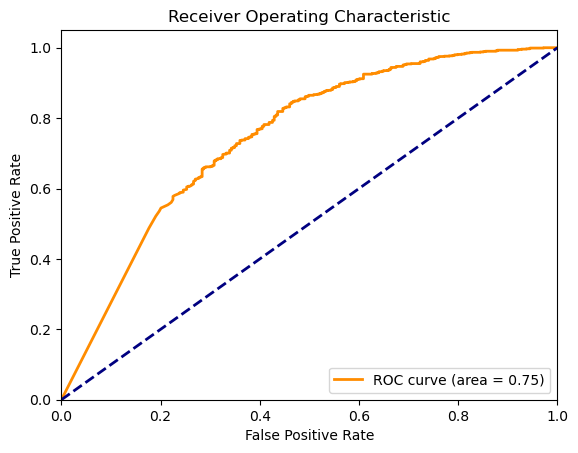

Time cost: 0.0002165729400228502ms
Accuracy of the model on the test images: 80.67%
Epoch [84/100], Loss: 0.0099
AUC: 0.7563
Dice Similarity Coefficient: 0.8810


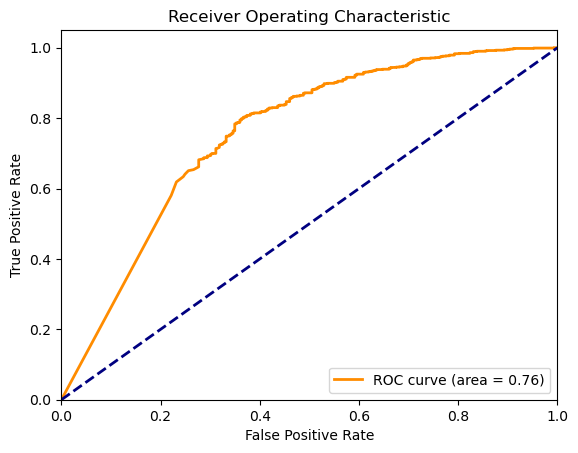

Time cost: 0.00022917514493340333ms
Accuracy of the model on the test images: 79.35%
Epoch [85/100], Loss: 0.0083
AUC: 0.7538
Dice Similarity Coefficient: 0.8702


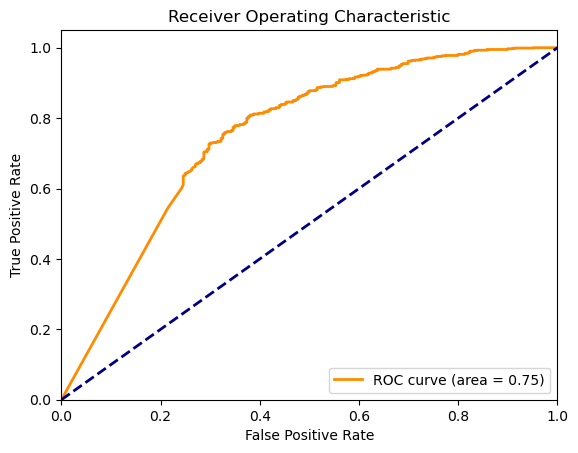

Time cost: 0.00021586235183799463ms
Accuracy of the model on the test images: 78.11%
Epoch [86/100], Loss: 0.0155
AUC: 0.7483
Dice Similarity Coefficient: 0.8611


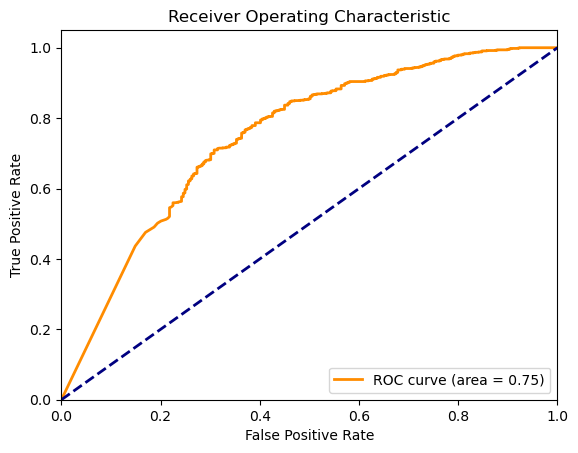

Time cost: 0.00022960287943984162ms
Accuracy of the model on the test images: 79.58%
Epoch [87/100], Loss: 0.0137
AUC: 0.7365
Dice Similarity Coefficient: 0.8785


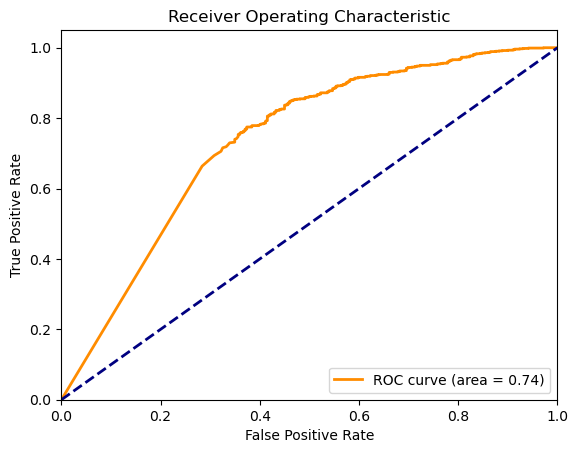

Time cost: 0.0002254282205293397ms
Accuracy of the model on the test images: 80.36%
Epoch [88/100], Loss: 0.0145
AUC: 0.7636
Dice Similarity Coefficient: 0.8794


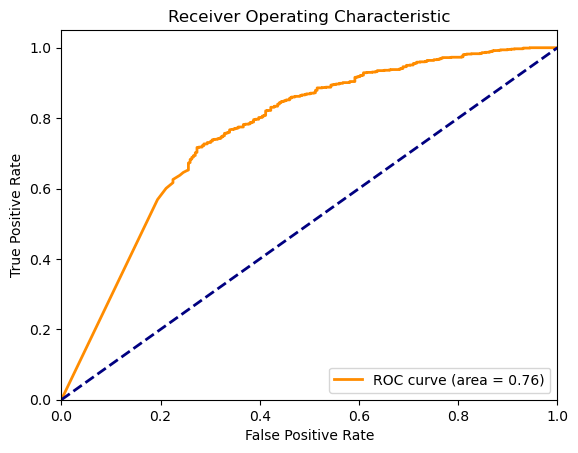

Time cost: 0.0002185112812039249ms
Accuracy of the model on the test images: 80.51%
Epoch [89/100], Loss: 0.0146
AUC: 0.7508
Dice Similarity Coefficient: 0.8800


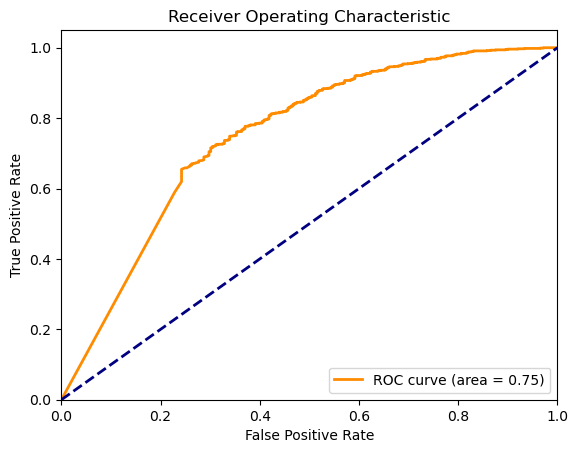

Time cost: 0.00022210566999395097ms
Accuracy of the model on the test images: 79.50%
Epoch [90/100], Loss: 0.0196
AUC: 0.7659
Dice Similarity Coefficient: 0.8694


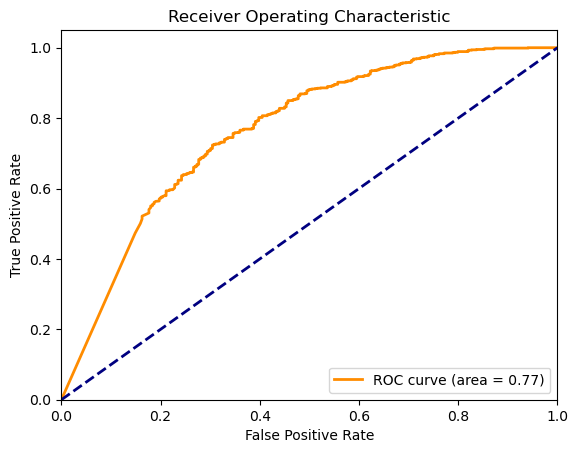

Time cost: 0.0002186561620319459ms
Accuracy of the model on the test images: 77.56%
Epoch [91/100], Loss: 0.0212
AUC: 0.7593
Dice Similarity Coefficient: 0.8550


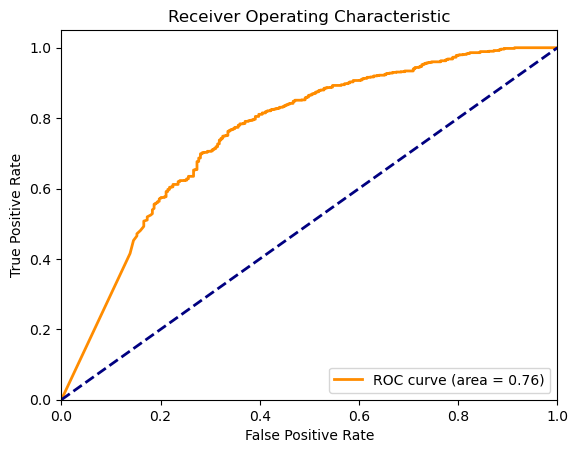

Time cost: 0.00021793493182750633ms
Accuracy of the model on the test images: 78.65%
Epoch [92/100], Loss: 0.0237
AUC: 0.7683
Dice Similarity Coefficient: 0.8642


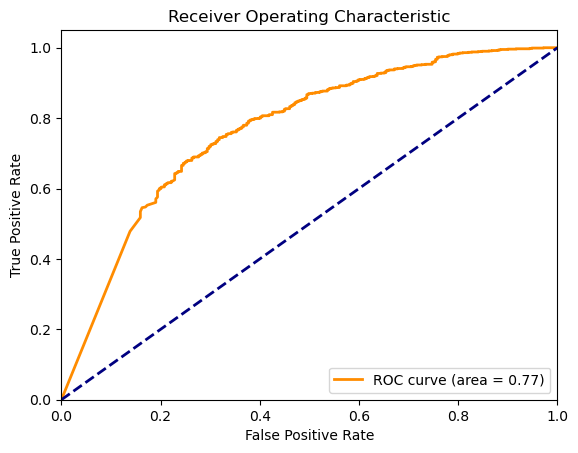

Time cost: 0.00021669989744946651ms
Accuracy of the model on the test images: 79.04%
Epoch [93/100], Loss: 0.0149
AUC: 0.7761
Dice Similarity Coefficient: 0.8659


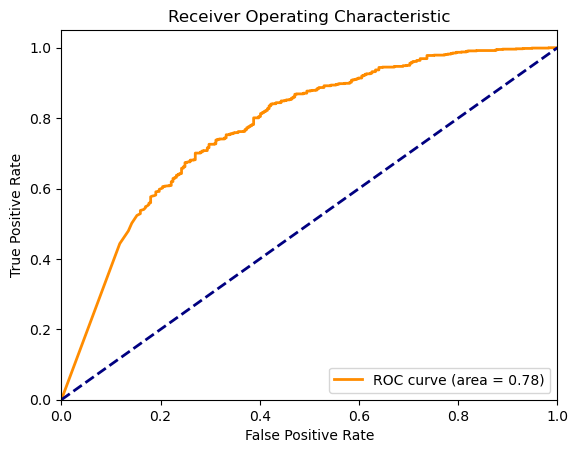

Time cost: 0.0002153726322350319ms
Accuracy of the model on the test images: 79.50%
Epoch [94/100], Loss: 0.0048
AUC: 0.7646
Dice Similarity Coefficient: 0.8717


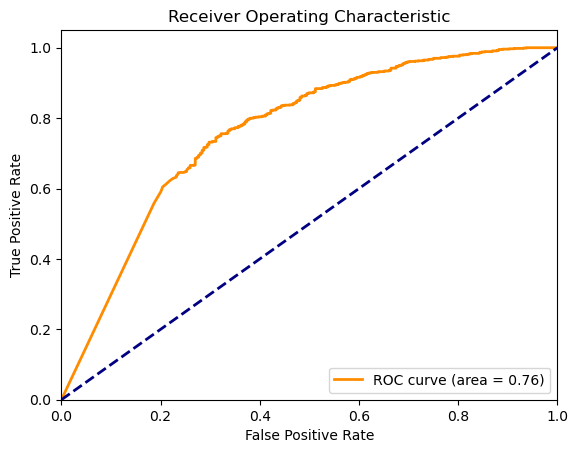

Time cost: 0.0002170867441964504ms
Accuracy of the model on the test images: 79.27%
Epoch [95/100], Loss: 0.0038
AUC: 0.7716
Dice Similarity Coefficient: 0.8685


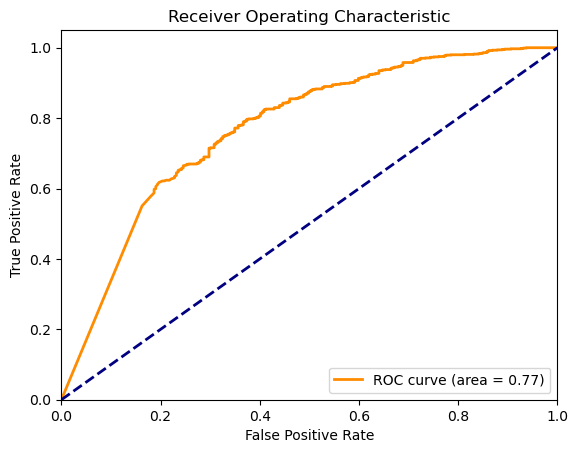

Time cost: 0.00022313607887262092ms
Accuracy of the model on the test images: 78.65%
Epoch [96/100], Loss: 0.0025
AUC: 0.7667
Dice Similarity Coefficient: 0.8634


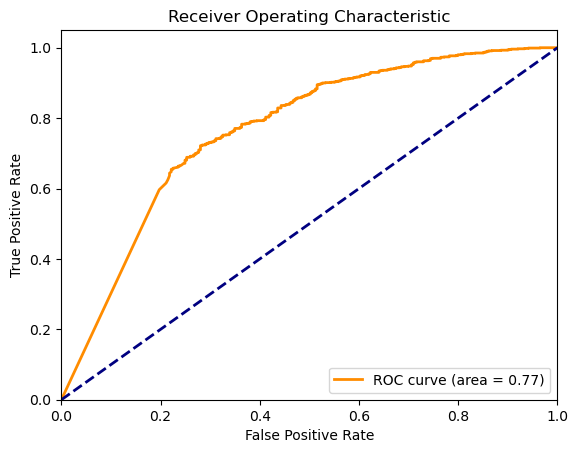

Time cost: 0.00022050357929131157ms
Accuracy of the model on the test images: 76.01%
Epoch [97/100], Loss: 0.0215
AUC: 0.7471
Dice Similarity Coefficient: 0.8454


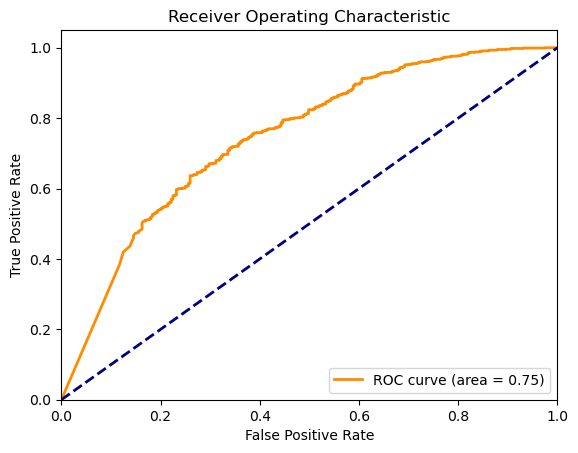

Time cost: 0.00022097388187608592ms
Accuracy of the model on the test images: 80.05%
Epoch [98/100], Loss: 0.0157
AUC: 0.7812
Dice Similarity Coefficient: 0.8746


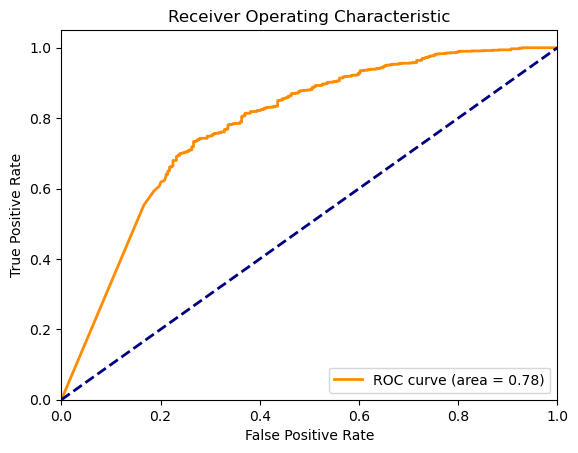

Time cost: 0.000230341099535196ms
Accuracy of the model on the test images: 78.80%
Epoch [99/100], Loss: 0.0022
AUC: 0.7589
Dice Similarity Coefficient: 0.8664


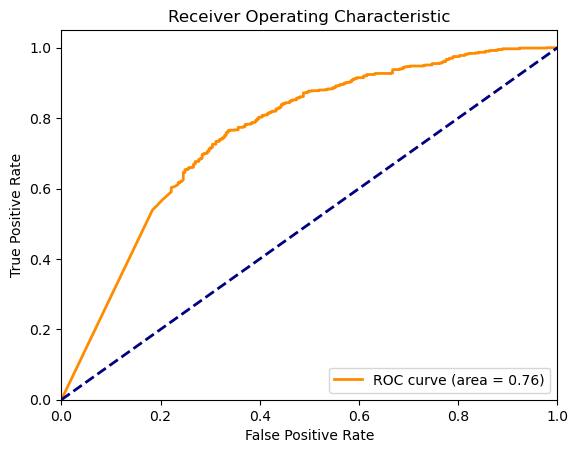

Time cost: 0.00022611080339950048ms
Accuracy of the model on the test images: 78.26%
Epoch [100/100], Loss: 0.0138
AUC: 0.7481
Dice Similarity Coefficient: 0.8626


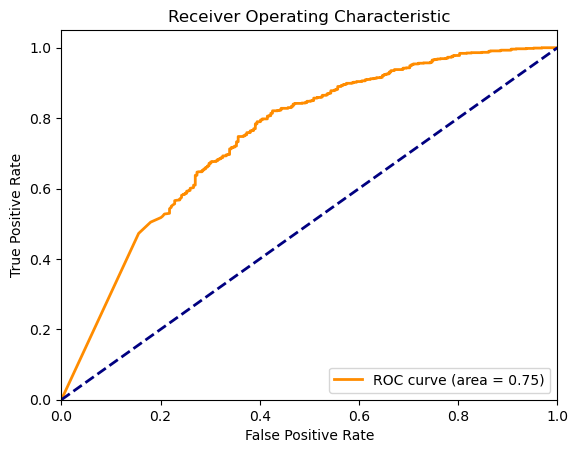

In [7]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,f1_score,mean_absolute_error,roc_curve
# 实例化模型
model = ResNet(ResidualBlock, 2)  # ResNet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.float()
        labels = labels.long()
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    

    #评估模型
    model.eval()
    all_probabilities = []
    all_labels = []
    all_predictions = []
    all_outputs = []
    correct = 0
    total = 0
    time_start = time.time()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            labels = labels.long()
            outputs = model(inputs)
            # 计算 AUC
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().detach().numpy()
            all_probabilities.extend(probabilities)
            all_labels.extend(labels.cpu().detach().numpy())
            
            # 计算 Dice 相似系数
            predictions = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            all_predictions.extend(predictions)
            
            # 计算 MAE
            all_outputs.extend(outputs.cpu().detach().numpy())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    time_end = time.time()
    print(f"Time cost: {(time_end - time_start)/1277}ms")
    print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    # 转换为 numpy 数组
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    all_predictions = np.array(all_predictions)
    all_outputs = np.array(all_outputs)

    # 计算 AUC
    auc = roc_auc_score(all_labels, all_probabilities)
    print(f"AUC: {auc:.4f}")

    # 计算 Dice 相似系数
    dice = f1_score(all_labels, all_predictions, average='binary')
    print(f"Dice Similarity Coefficient: {dice:.4f}")

    # 计算 MAE
    # mae = mean_absolute_error(all_labels, all_outputs)
    # print(f"Mean Absolute Error: {mae:.4f}")

    # 计算 ROC 曲线
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)

    # 绘制 ROC 曲线
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# 评估模型
# model.eval()
# correct = 0
# total = 0
# time_start = time.time()
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         inputs = inputs.float()
#         labels = labels.long()
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# time_end = time.time()
# print(f"Time cost: {time_end - time_start:.2f}s")
# print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")